<a href="https://colab.research.google.com/github/oliverzannino/oliverza/blob/main/Risk_Management_Assessment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oliver Zannino 37009 Assessment 2

Student #: 26123517

# **Section 4.1 - Data Preparation and Risk Factor Mapping**

 **Task 4.1.1**

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats, optimize
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('AT2StockPriceData.csv')
df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.head()

,Date,AAPL,IBM
Date,,,
1999-12-31,31/12/1999,0.7716,53.6409
2000-01-03,3/1/2000,0.8402,57.6784
2000-01-04,4/1/2000,0.7694,55.7194
2000-01-05,5/1/2000,0.7806,57.6784
2000-01-06,6/1/2000,0.7130,56.6840


In [2]:
# construct the time series of overlapping
df['AAPL_log_return'] = np.log(df['AAPL'] / df['AAPL'].shift(1))
df['IBM_log_return'] = np.log(df['IBM'] / df['IBM'].shift(1))
df['AAPL_10d_log_return'] = df['AAPL_log_return'].rolling(window=10).sum()
df['IBM_10d_log_return'] = df['IBM_log_return'].rolling(window=10).sum()

# ensure df consists only of 10d log returns for AAPL and IBM
df = df[['AAPL_10d_log_return', 'IBM_10d_log_return']]
df = df.dropna(subset=['AAPL_10d_log_return', 'IBM_10d_log_return'])

In [3]:
mean_10d_log_return_aapl = df['AAPL_10d_log_return'].mean()
mean_10d_log_return_ibm = df['IBM_10d_log_return'].mean()

print(f"Mean 10-day log return for AAPL: {mean_10d_log_return_aapl:.4f}")
print(f"Mean 10-day log return for IBM: {mean_10d_log_return_ibm:.4f}")

Mean 10-day log return for AAPL: 0.0089
Mean 10-day log return for IBM: 0.0022


In [4]:
# Function for EWMA estimator of the returns time series
def EWMA_cov(returns_time_series, time, smoothing_constant):
  # - Inputs
  # returns_time_series: time series as a data frame # time: time (index) at which the EWMA covariance matrix estimate is to be calculated (must be an integer from 1 to
  # no. of rows of returns_time_series - 1)
    # smoothing_constant (theta): EWMA smoothing parameter
  data = returns_time_series
  theta = smoothing_constant
# - Return error message if time is incorrect
  if (time < 1 or time > (data.shape[0])):
    print("Invalid `time` value")
# - Perform recursion to update EWMA covariance matrix up until specified time
  else:
# - Extract the time series of specified length from the input time series
    data_extract = data.head(time)
# - Normalize the returns and convert to a numpy array
    normalized = (data_extract - data_extract.mean()).fillna(0).to_numpy()
# - Calculate the weights
    weights = (1 - theta) ** np.arange(len(data_extract))[::-1]
# - Calculate EWMA estimate of covariance matrix
    cov = (weights * normalized.T) @ normalized * theta
    return cov

In [5]:
#EWMA cov matrix
ewma_log_ret_cov = EWMA_cov(df, len(df), 0.04)
print(f"EWMA covariance matrix")
print(ewma_log_ret_cov.round(4))

EWMA covariance matrix
[[ 0.0031 -0.0006]
 [-0.0006  0.0052]]


**Task 4.1.2**

In [11]:
AAPL_ann_vol = np.sqrt(ewma_log_ret_cov[0,0] * (250/10))
IBM_ann_vol = np.sqrt(ewma_log_ret_cov[1,1] * (250/10))

print(f"Estimated annual volatility for AAPL via EWMA (σ̂₁): {AAPL_ann_vol:.4f}")
print(f"Estimated annual volatility for IBM via EWMA (σ̂₂): {IBM_ann_vol:.4f}")

Estimated annual volatility for AAPL via EWMA (σ̂₁): 0.2801
Estimated annual volatility for IBM via EWMA (σ̂₂): 0.3607


**Task 4.1.3**

In [12]:
# Pricing function for European calls and puts
def BSprice(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):

    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility

    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    # Calculate option prices
    if option_type == 'call':
        price = (np.exp(-q * tau) * s * stats.norm.cdf(d1, 0.0, 1.0) \
                 - np.exp(-r * tau) * K * stats.norm.cdf(d2, 0.0, 1.0))

    if option_type == 'put':
        price = (np.exp(-r * tau) * K * stats.norm.cdf(-d2, 0.0, 1.0) \
                 - np.exp(-q * tau) * s * stats.norm.cdf(-d1, 0.0, 1.0))

    return price

In [13]:
# Function to calculate option delta under the Black-Scholes-Merton model
def BSdelta(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):

    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility

    # Calculate d1 and d2
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))

    # Calculate option delta
    if option_type == 'call':
        value = stats.norm.cdf(d1, 0.0, 1.0)

    if option_type == 'put':
        value = stats.norm.cdf(d1, 0.0, 1.0) - 1

    return value

In [15]:
# Function to calculate option gamma under the Black-Scholes-Merton model
def BSgamma(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility):

    # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity # (T-t) in notes
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility

    # Compute option gamma (same for calls and puts)
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    value = stats.norm.pdf(d1, 0.0, 1.0) / (s * sigma * np.sqrt(tau))

    return value

In [16]:
def BStheta(spot_price, strike_price, time_to_maturity, risk_free_rate, dividend_yield, volatility, option_type):

 # Use mathematical notation for function inputs
    s = spot_price
    K = strike_price
    tau = time_to_maturity  # (T - t)
    r = risk_free_rate
    q = dividend_yield
    sigma = volatility

    #compute option theta
    d1 = (np.log(s / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    if option_type == 'call':
        value = -(s * stats.norm.pdf(d1,0.0,1.0) * sigma * np.exp(-q * tau)) / (2 * np.sqrt(tau)) \
                - r * K * np.exp(-r * tau) * stats.norm.cdf(d2,0.0,1.0) \
                + q * s * stats.norm.cdf(d1,0.0,1.0) * np.exp(-q * tau)

    if option_type == 'put':
        value = -(s * stats.norm.pdf(d1,0.0,1.0) * sigma * np.exp(-q * tau)) / (2 * np.sqrt(tau)) \
                + r * K * np.exp(-r * tau) * stats.norm.cdf(-d2,0.0,1.0) \
                - q * s * stats.norm.cdf(-d1,0.0,1.0) * np.exp(-q * tau)

    return value

In [17]:
r_f = 0.035
AAPLprice = 231.59
IBMprice = 239.72

#call prices

AAPLcall = BSprice(AAPLprice, AAPLprice, 3/12, r_f, 0, AAPL_ann_vol, 'call')
IBMcall = BSprice(IBMprice, IBMprice, 6/12, r_f, 0, IBM_ann_vol, 'call')

#call delta
AAPLcall_delta = BSdelta(AAPLprice, AAPLprice, 3/12, r_f, 0, AAPL_ann_vol, 'call')
IBMcall_delta = BSdelta(IBMprice, IBMprice, 6/12, r_f, 0, IBM_ann_vol, 'call')

#call gamma
AAPLcall_gamma = BSgamma(AAPLprice, AAPLprice, 3/12, r_f, 0, AAPL_ann_vol)
IBMcall_gamma = BSgamma(IBMprice, IBMprice, 6/12, r_f, 0, IBM_ann_vol)

#call theta
AAPLcall_theta = BStheta(AAPLprice, AAPLprice, 3/12, r_f, 0, AAPL_ann_vol, 'call')
IBMcall_theta = BStheta(IBMprice, IBMprice, 6/12, r_f, 0, IBM_ann_vol, 'call')

print(f"Price of AAPL call option: {AAPLcall:.4f}")
print(f"AAPL call delta: {AAPLcall_delta:.4f}")
print(f"AAPL call gamma: {AAPLcall_gamma:.4f}")
print(f"AAPL call theta: {AAPLcall_theta:.4f}")
print("--------------")
print(f"Price of IBM call option: {IBMcall:.4f}")
print(f"IBM call delta: {IBMcall_delta:.4f}")
print(f"IBM call gamma: {IBMcall_gamma:.4f}")
print(f"IBM call theta: {IBMcall_theta:.4f}")

Price of AAPL call option: 13.9077
AAPL call delta: 0.5527
AAPL call gamma: 0.0122
AAPL call theta: -29.6484
--------------
Price of IBM call option: 26.2520
IBM call delta: 0.5778
IBM call gamma: 0.0064
IBM call theta: -27.8571


**Task 4.1.4** - Derivation for delta-gamma loss approximation

$$
\begin{aligned}
V(t, z_1, z_2) &= C_{\text{AAPL}}(t, e^{z_1})
- \eta_1 S_{\text{AAPL}}(t, e^{z_1, t})
+ C_{\text{IBM}}(t, e^{z_2,t}) - \eta_2S_{\text{IBM}}(t, e^{z_2 t})
\end{aligned}
$$

Notation:
$S_{i,t} = e^{z_{i,t}} \quad \text{for } i = 1, 2 $

where i = 1 refers to AAPL, i = 2 refers to IBM

T+1 = Δt = difference in time period that the risk factors are measured between (10 days)

$$
\begin{aligned}
L_{t+1} &= -(V(t + \Delta t, z_1 + X_{1, t+1}, z_2 + X_{2, t+1}) - V(t, z_{1,t}, z_{2,t})) \\
X_{t+1} &= \begin{pmatrix} X_{1, t+1} \\ X_{2, t+1} \end{pmatrix}, \quad z_t = (z_{1,t}, z_{2,t})
\end{aligned}
$$

Using a Taylor expansion:

$$
\begin{aligned}
V(t + \Delta t, z_1 + X_{1,t+1}, z_2 + X_{2,t+1}) - V(t, z_1, z_2) &\approx \frac{\partial V}{\partial t} \Delta t + \frac{\partial V}{\partial z_1} X_{1,t+1} + \frac{\partial V}{\partial z_2} X_{2,t+1} \\
&\quad + \frac{1}{2} \frac{\partial^2 V}{\partial z_1^2} X_{1,t+1}^2 +
\frac{1}{2} \frac{\partial^2 V}{\partial z_2^2} X_{2,t+1}^2 + \frac{\partial^2 V}{\partial z_1 \partial z_2} X_{1,t+1} X_{2,t+1} \\
\end{aligned}
$$

Ignore the cross term as the question mentioned

---

**Partial Derivative**: $\frac{\partial V}{\partial t}$

$$
\frac{\partial V}{\partial t} = \frac{\partial C_{\text{AAPL}}}{\partial t}(t, e^{z_1}) + \frac{\partial C_{\text{AAPL}}}{\partial e^{z_1}}(t, e^{z_1}) \frac{\partial e^{z_1}}{\partial t} - \eta1 \frac{\partial e^{z_1}}{\partial t} + \frac{\partial C_{\text{IBM}}}{\partial t}(t, e^{z_2}) + \frac{\partial C_{\text{IBM}}}{\partial e^{z_2}}(t, e^{z_2}) \frac{\partial e^{z_2}}{\partial t} - \eta2 \frac{\partial e^{z_2}}{\partial t}
$$

But:

$\frac{\partial e^{z_1}}{\partial t} = \frac{\partial e^{z_2}}{\partial t} $= 0



So:

$$
c_t = \left( \theta_{\text{AAPL}, t} + \theta_{\text{IBM}, t} \right)\Delta t
$$

---

**Partial Derivative**: $\frac{\partial V}{\partial z_1}$ and $\frac{\partial V}{\partial z_2}$


$$
\begin{aligned}
\frac{\partial V}{\partial z_1}
&= \frac{\partial C_{\text{AAPL}}}{\partial e^{z_1}} \frac{\partial e^{z_1}}{\partial z_1} - \eta_1  \frac{\partial e^{z_1}}{\partial z_1} \\
& \text{(since } \frac{\partial t}{\partial z_1} = 0 \text{ and } \frac{\partial e^{z_1}}{\partial z_1} = e^{z_1} \text{)} \\
&= \Delta_{\text{AAPL},1} e^{z_1} - \eta_1 e^{z_1}
\end{aligned}
$$

Alternative form:

$$
\frac{\partial V}{\partial z_1} = S_{\text{AAPL}} \left( \Delta_{\text{AAPL}} - \eta_1 \right)
$$

Similarly,

$$
\frac{\partial V}{\partial z_2} = S_{\text{IBM}} \left( \Delta_{\text{IBM}} - \eta_2 \right)
$$

$$
\small
\mathbf{b}_t =
\begin{pmatrix}
S_{\text{AAPL}} \left( \Delta_{\text{AAPL}} - \eta_1 \right) & 0 \\
0 & S_{\text{IBM}} \left( \Delta_{\text{IBM}} - \eta_2 \right)
\end{pmatrix}
$$

---

**Second Derivatives**: $\frac{\partial^2 V}{\partial z_1^2}$ and $\frac{\partial^2 V}{\partial z_2^2}$
$$
\begin{aligned}
\frac{\partial^2 V}{\partial z_1^2}
&= \frac{\partial}{\partial z_1} \left( e^{z_1} (\Delta_{1,t} - \eta_1)  \right)  = \frac{\partial e^{z_1}}{\partial z_1} (\Delta_{1,t} - \eta_1) + e^{z_1} \frac{\partial (\Delta_{1,t} - \eta_1)}{\partial z_1}\\
&= e^{z_1} (\Delta_{1,t} - \eta_1) + e^{z_1} \frac{\partial \Delta_{1,t}}{\partial e^{z_1}} \frac{\partial e^{z_1}}{\partial z_1} \\
&= e^{z_1} (\Delta_{1,t} - \eta_1) + e^{2 z_1} \Gamma_{1,t} \\
&= S_{1,t} (\Delta_{1,t} - \eta_1) + \Gamma_{1,t} S_{1,t}^2
\end{aligned}
$$

Similarly,

$$
\frac{\partial^2 V}{\partial z_2^2} = S_{2,t} (\Delta_{2,t} - \eta_2) + \Gamma_{2,t} S_{2,t}^2
$$

Define:

$$
B_t = \begin{bmatrix}
S_{1,t} (\Delta_{1,t} - \eta_1) + \Gamma_{1,t} S_{1,t}^2 & 0 \\
0 & S_{2,t} (\Delta_{2,t} - \eta_2) + \Gamma_{2,t} S_{2,t}^2
\end{bmatrix}
$$

---

**Final Delta-Gamma Loss Approximation**

$$
\begin{aligned}
L_{t+1}^{\Delta,\Gamma} &= -\left( \theta_{1,t} + \theta_{2,t} \right) \Delta t \\
&\quad - \begin{bmatrix}
S_{1,t} (\Delta_{1,t} - \eta_1) \\
S_{2,t} (\Delta_{2,t} - \eta_2)
\end{bmatrix}^\top
\begin{bmatrix}
X_{1,t+1} \\
X_{2,t+1}
\end{bmatrix} \\
&\quad - \frac{1}{2}
\begin{bmatrix}
X_{1,t+1} \\
X_{2,t+1}
\end{bmatrix}^\top
\begin{bmatrix}
S_{1,t} (\Delta_{1,t} - \eta_1) + \Gamma_{1,t} S_{1,t}^2 & 0 \\
0 & S_{2,t} (\Delta_{2,t} - \eta_2) + \Gamma_{2,t} S_{2,t}^2
\end{bmatrix}
\begin{bmatrix}
X_{1,t+1} \\
X_{2,t+1}
\end{bmatrix}
\end{aligned}
$$


**Task 4.1.5**

In [18]:
#c_t

theta1 = np.array(AAPLcall_theta)
theta2 = np.array(IBMcall_theta)

portfoliotheta = theta1+theta2
scaledportfoliotheta = portfoliotheta * 10/250
print(f"Annualized portfolio theta: {portfoliotheta:.4f}")
print(f"Scaled portfolio theta: {scaledportfoliotheta:.4f}")
print(f"c_t: {scaledportfoliotheta:.4f}")


Annualized portfolio theta: -57.5056
Scaled portfolio theta: -2.3002
c_t: -2.3002


In [19]:
# for b_t

n1 = 1
n2 = 1

AAPL_exposure = (AAPLcall_delta - n1) * AAPLprice
IBM_exposure  = (IBMcall_delta - n2) * IBMprice

# Now place them in a vector
portfolio_exposure = np.array([
    AAPL_exposure,
    IBM_exposure
])

print("b_t vector:", np.round(portfolio_exposure, 4))

b_t vector: [-103.5886 -101.2216]


In [20]:
#B_t

portfoliogammaexposure = np.zeros([df.shape[1], df.shape[1]])
portfoliogammaexposure[0,0] = AAPLcall_gamma*AAPLprice**2 + (AAPLcall_delta - n1)*AAPLprice
portfoliogammaexposure[1,1] = IBMcall_gamma*IBMprice**2 + (IBMcall_delta - n2)*IBMprice
print("B_t matrix:", np.round(portfoliogammaexposure,4))

B_t matrix: [[550.2792   0.    ]
 [  0.     266.5728]]


# **Section 4.2.1 - Analytical Approach**

**Task 4.2.1.1**

In [21]:
#Var under analytical approach

# Confidence level
conf_level = 0.99

# Functions for VaR and ES under the variance-covariance approach
def VaR_ES_vcv(constant_loss, risk_exposure, risk_factor_mean, risk_factor_cov_mat, conf_level):

    # Shorthand notation for inputs
    c = constant_loss
    b = risk_exposure
    mu = risk_factor_mean
    Sigma = risk_factor_cov_mat
    alpha = conf_level

    # Compute mean and variance of loss
    loss_mean = -c - np.transpose(b) @ mu
    loss_var = np.transpose(b) @ Sigma @ b

    # Compute VaR
    VaR = loss_mean + np.sqrt(loss_var) * stats.norm.ppf(alpha, loc = 0.0, scale = 1.0)
    VaR = max(VaR, 0)

    # Compute ES
    ES = loss_mean + np.sqrt(loss_var) * stats.norm.pdf(stats.norm.ppf(alpha, loc = 0.0, scale = 1.0), loc = 0.0, scale = 1.0) / (1 - alpha)
    ES = max(ES, 0)

    # Return output
    return np.array([VaR, ES])

In [22]:
df_mean = np.mean(df, axis = 0)

portfolio_risk_measures = VaR_ES_vcv(scaledportfoliotheta, portfolio_exposure, df_mean, ewma_log_ret_cov, conf_level)
print('Analytical 10 day 99% VaR and ES for portfolio:')
print(np.round(portfolio_risk_measures, 4))

Analytical 10 day 99% VaR and ES for portfolio:
[23.6119 26.5496]


**Task 4.2.1.2**

Under the analytical/variance-covariance approach:

**VaR interpretation**: With 99% confidence, the portfolio loss over the next 10 days will not exceed \$23.6119.  
Said another way, there is a 1% probability that the portfolio will incur a loss greater than \$23.6119 over the next 10 days.

**ES interpretation**: In the event that the portfolio loss over the next 10 days exceeds \$23.6119, the expected average loss is \$26.5496.


# **Section 4.2.2 - Historical Simulation**

**Task 4.2.2.1 - Standard HS with delta-gamma approx**

In [23]:
#define empirical VaR/ES function

def VaR_ES_emp(loss_scenarios, conf_level, hs_weight_type, age_weight_decay = 0.94):

    # Inputs:
    # loss_scenarios - array of historically simulated loss amounts, arranged from least recent to most recent
    # conf_level - risk measure confidence level
    # hs_sim_type - "equal" or "age"
    #     "equal": traditional historical simulation, loss scenarios equally weighted and quantile is linearly interpolated
    #     "BRW": BRW approach with exponentially decaying weights
    #          : Requires "age_weight_decay" parameter

    if hs_weight_type == "equal":

        # Determine the VaR (empirical quantile, linearly interpolated)
        VaR = np.quantile(loss_scenarios, conf_level, method = "higher")

        # Note: Other methods are available. "higher" corresponds to the non-interpolated estimate of the VaR.
        # Refer to the documentation of np.quantile() for a complete list of methods.

        # Determine the ES
        ES = np.maximum(loss_scenarios - VaR, 0).mean() / (1 - conf_level) + VaR

    elif hs_weight_type == "BRW":

        # Calculate exponentially decaying weights
        weights = age_weight_decay ** np.arange(len(loss_scenarios))[::-1] * (1 - age_weight_decay) / (1 - age_weight_decay ** len(loss_scenarios))

        # Append weights to historical simulations and sort in increasing order of the loss
        loss_weighted = np.column_stack((loss_scenarios, weights))
        loss_weighted = loss_weighted[loss_weighted[:,0].argsort()]

        # Calculate cumulative weights and append to loss_weighted
        cumulative_weight = np.cumsum(loss_weighted[:,1])
        loss_weighted = np.column_stack((loss_weighted, cumulative_weight))

        # Determine the VaR
        loss_exceed = loss_weighted[(loss_weighted[:,2] >= conf_level)]
        VaR = min(loss_exceed[:,0])

        # Calculate the ES
        ES = sum((loss_exceed[:,0] - VaR) * loss_exceed[:,1]) / (1 - conf_level) + VaR

    # Return output
    return np.array([VaR, ES])

In [24]:
# Standard historical sim using delta gamma approx
loss_scenarios = -scaledportfoliotheta -np.matmul(df.to_numpy(), portfolio_exposure) -0.5 *np.diag(np.matmul(df.to_numpy(),np.matmul(portfoliogammaexposure, df.to_numpy().T)))

rm_hs = VaR_ES_emp(loss_scenarios, conf_level, hs_weight_type="equal")
print('10 day 99% Portfolio VaR using HS (delta-gamma):', round(rm_hs[0], 4))
print('10 day 99% Portfolio ES using HS (delta-gamma):', round(rm_hs[1], 4))

10 day 99% Portfolio VaR using HS (delta-gamma): 20.0579
10 day 99% Portfolio ES using HS (delta-gamma): 23.018


**Task 4.2.2.1 - Standard HS with FV approach**

In [25]:
# full valuation approach (standard historical sim)

AAPLscen = AAPLprice * np.exp(df['AAPL_10d_log_return'])
IBMscen = IBMprice * np.exp(df['IBM_10d_log_return'])
delta_t = 10/250

# Option price scenarios
AAPL_call_scenarios = BSprice(AAPLscen, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call') # need to subtract delta_t
IBM_call_scenarios = BSprice(IBMscen, IBMprice, 6/12-delta_t, r_f, 0, IBM_ann_vol, 'call')

# Portfolio loss scenarios
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios = AAPL_call_scenarios + IBM_call_scenarios - 1*AAPLscen - 1*IBMscen
loss_scenarios_fv = -(portfolio_scenarios - portfolio_value)

# Calculate risk measures using FV standard historical simulation
rm_hs_fv = VaR_ES_emp(loss_scenarios_fv, conf_level = conf_level, hs_weight_type = "equal")

print('10 day 99% Portfolio VaR using FV HS: ', round(rm_hs_fv[0],4))
print('10 day 99% Portfolio ES using FV HS: ', round(rm_hs_fv[1],4))

10 day 99% Portfolio VaR using FV HS:  19.989
10 day 99% Portfolio ES using FV HS:  23.1564


**Comparison of the two standard HS measures**

The VaR and ES under both methods of standard historical simulation are quite similar in magnitude, however the VaR is larger under the delta-gamma approximation while the ES is larger under the full valuation approach. These differences arise because the delta-gamma approximation is derived from a second-order Taylor's expansion which includes the effects of delta, gamma and theta (as seen in the 4.1.4 derivation) and treated as constant over the time horizon. This method assumes a quadratic relationship between risk factors and portfolio value. Conversely, the full valuation method reprices the portfolio under each historical scenario and considers additional a broader set of effects/greeks (e.g. vega, non-linearity) on the portfolio value. This makes the full valuation a more appropriate form of calculation during times of tail risk/extreme losses, and may be a reason why the ES is larger under full valuation because it captures more severe losses beyond the VaR threshold.

**Task 4.2.2.2 - Age Weighted HS with Delta-Gamma Approximation**

In [26]:
# standard HS using age weighted
rm_hs_aw = VaR_ES_emp(loss_scenarios, conf_level, hs_weight_type="BRW", age_weight_decay=0.94)
print('10 day 99% Portfolio VaR using age-weighted HS (delta-gamma):', round(rm_hs_aw[0], 4))
print('10 day 99% Portfolio ES using age-weighted HS (delta-gamma):', round(rm_hs_aw[1], 4))

10 day 99% Portfolio VaR using age-weighted HS (delta-gamma): 11.9942
10 day 99% Portfolio ES using age-weighted HS (delta-gamma): 13.2211


**Task 4.2.2.2 - Age Weighted FV HS**

In [27]:
# Calculate FV VaR and ES using age-weighted historical simulation with decay parameter 0.94
rm_hs_aw_fv = VaR_ES_emp(loss_scenarios_fv, conf_level, hs_weight_type = "BRW", age_weight_decay = 0.94)
print('10 day 99% Portfolio VaR using age-weighted FV HS: ', round(rm_hs_aw_fv[0],4))
print('10 day 99% Portfolio ES using age-weighted FV HS: ', round(rm_hs_aw_fv[1],4))

10 day 99% Portfolio VaR using age-weighted FV HS:  12.0524
10 day 99% Portfolio ES using age-weighted FV HS:  13.2682


**Comparison of the two age-weighted HS measures**

The age-weighted HS measures with decay parameter = 0.94 give more weight to the recent observations to reflect the idea that recent market behaviour is more relevant to current risk than older data. Like the above comparison, the delta-gamma uses the second-order Taylor's expansion, whilst the full valuation revalues the entire portfolio under each scenario, capturing non-linear effects. The output shows that the FV approach results in slightly higher estimates of both VaR and ES than the Delta-Gamma approximation. This may be due to recent market moves causing larger non-linear losses that the delta-gamma approximation underestimates. Since recent losses are more heavily weighted, this increases the VaR and ES under full valuation more so than under delta-gamma approximation.

**Task 4.2.2.3 - Comparison of standard vs. age-weighted HS measures**

The most notable difference between the standard and age-weighted historical simulation (HS) measures is the significant decrease in VaR and ES under the age-weighted HS approach. Since this method gives more weight to recent observations, the substantial decrease likely reflects a period of lower volatility and fewer tail losses in recent data compared to earlier periods. This is seen in the below line chart, as the 30d rolling standard deviation decreases with time (on average). In contrast, the equal-weighted standard HS approach treats all past data as equally relevant, which can cause risk measures to be inflated vs. age weighted.

For VaR, the standard HS produces higher values than the age-weighted HS, indicating that historical volatility was higher in the past than more recently. This suggests that risk has decreased recently, and the age-weighted HS better captures this by down-weighting older, riskier periods.

Regarding ES, it is slightly higher under full valuation in both cases, reflecting the fact that full valuation captures heavier tail risks and nonlinear effects that the delta-gamma approximation tends to underestimate.

Conclusion: Age-weighted HS provides a more timely and responsive risk estimate, while standard HS may overstate current levels of risk due to equal treatment of outdated scenarios. Differences between the methods are more pronounced in volatile or nonlinear portfolios, and age-weighted HS combined with FV gives the most responsive and accurate estimate of current risk.

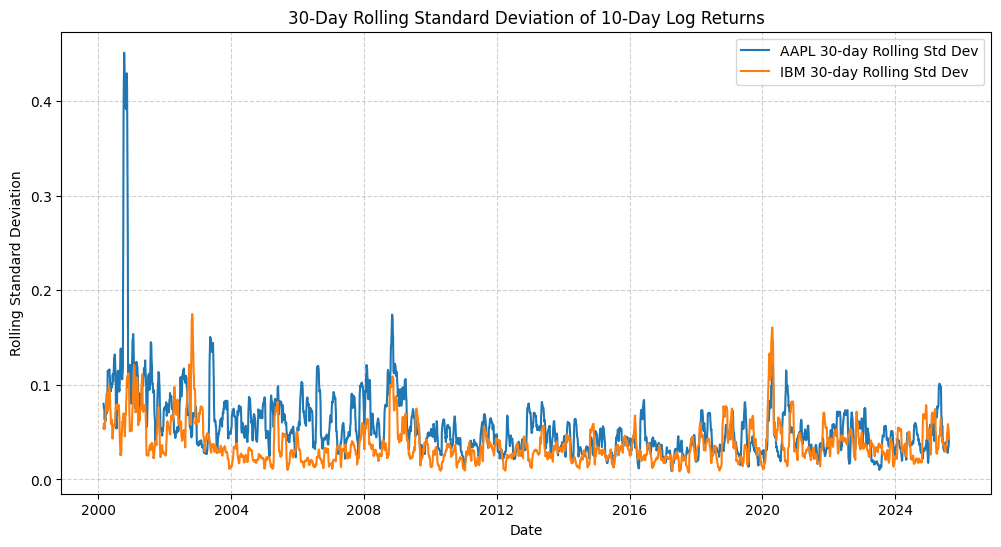

In [28]:
# Calculate the 30-day rolling standard deviation for each column. Reference to CoPilot below.
rolling_std = df.rolling(window=30).std()

# Create a line plot of the rolling standard deviations
plt.figure(figsize=(12, 6))
plt.plot(rolling_std.index, rolling_std['AAPL_10d_log_return'], label='AAPL 30-day Rolling Std Dev')
plt.plot(rolling_std.index, rolling_std['IBM_10d_log_return'], label='IBM 30-day Rolling Std Dev')
plt.title('30-Day Rolling Standard Deviation of 10-Day Log Returns')
plt.xlabel('Date')
plt.ylabel('Rolling Standard Deviation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [30]:
## Comparison of all measures in 4.2.2

import pandas as pd

# Create a dictionary with the results
data = {
    'Method': ['Standard HS', 'Full Valuation HS', 'Age-Weighted HS', 'Age-Weighted FV HS'],
    'VaR': [rm_hs[0], rm_hs_fv[0], rm_hs_aw[0], rm_hs_aw_fv[0]],
    'ES': [rm_hs[1], rm_hs_fv[1], rm_hs_aw[1], rm_hs_aw_fv[1]]
}

# Create a pandas DataFrame
results_table = pd.DataFrame(data)

# Display the table with values formatted to 4 decimal places
display(results_table.style.format({'VaR': '{:.4f}', 'ES': '{:.4f}'}))

,Method,VaR,ES
0,Standard HS,20.0579,23.0180
1,Full Valuation HS,19.9890,23.1564
2,Age-Weighted HS,11.9942,13.2211
3,Age-Weighted FV HS,12.0524,13.2682


# **Section 4.2.3 - Monte Carlo Simulation**

**Task 4.2.3.1 - Pseudo observations and MLE**

In [31]:
from scipy.stats import rankdata, t

#initially rank the data
log_ret_rank = stats.rankdata(df, axis = 0)
n = np.size(df, axis = 0)
ps_obs_ecdf = log_ret_rank / (n + 1)

# Split pseudo-observations into two arrays
u = ps_obs_ecdf[:, 0]  # first column
v = ps_obs_ecdf[:, 1]  # second column
print(np.round(ps_obs_ecdf, 4))

[[0.2786 0.9806]
 [0.1035 0.4355]
 [0.6694 0.9231]
 ...
 [0.9394 0.0589]
 [0.9464 0.0836]
 [0.9722 0.1689]]


In [32]:
# Construct the NEGATIVE log-likelihood function for the Student's t copula

def neg_loglik_t(pars, u, v):
    # Parameters for the multivariate t distribution
    nu = pars[0]
    rho = pars[1]
    cov_mat = [[1, rho], [rho, 1]]

    # Compute the inverse of the univariate cdf at the pseudo-observations
    F_inv1 = stats.t.ppf(u, df = nu)
    F_inv2 = stats.t.ppf(v, df = nu)

    # Calculate the log-likelihood
    numerator = stats.multivariate_t.pdf(np.array([F_inv1, F_inv2]).T, loc = None, shape = cov_mat, df = nu, allow_singular = False)
    denominator = stats.t.pdf(F_inv1, df = nu) * stats.t.pdf(F_inv2, df = nu)

    ratio = numerator / denominator
    ratio = ratio[~np.isnan(ratio)]    # In case the process above generates NaNs

    value = -np.sum(np.log(ratio))
    return value

In [33]:
# Find MLE estimates

## - Initial values
init_pars = [2, 0.1]

## - Parameter bounds
bnds = ((0, None), (-0.999999, 0.999999))

# If -1 and 1 are included in the bounds, the optimization algorithm picks up the boundary solution, which is inconsistent with the dependence analysis above.

## - Implement optimization
tcop_pars = optimize.minimize(neg_loglik_t, init_pars, args = (u, v), bounds = bnds)

## - Extract optimal parameters
tcop_df = tcop_pars.x[0]
tcop_rho = tcop_pars.x[1]
tcop_cov = [[1, tcop_rho], [tcop_rho, 1]]

In [34]:
tcop_emp_pars = optimize.minimize(neg_loglik_t, init_pars, args = (u, v), bounds = bnds)
print(f"t copula df: {tcop_df:.4f}")
print(f"t copula rho: {tcop_rho:.4f}")

t copula df: 7.8916
t copula rho: 0.3477


**Task 4.2.3.2 - Coefficients of dependence, scatter plot and discussion**

In [35]:
!pip install pycop
import pycop

In [36]:
em_cop = pycop.empirical((df[['AAPL_10d_log_return', 'IBM_10d_log_return']]).T.values)

print(f"Lower Tail Dependence Coefficient (0.01): {em_cop.LTDC(0.01):.4f}")
print(f"Upper Tail Dependence Coefficient (0.99): {em_cop.UTDC(0.99):.4f}")

Lower Tail Dependence Coefficient (0.01): 0.1399
Upper Tail Dependence Coefficient (0.99): 0.1663


In [37]:
# estimated parameters from MLE
nu = tcop_df
rho = tcop_rho

# Compute the argument inside the t CDF
arg = - np.sqrt((nu + 1) * (1 - rho) / (1 + rho))

# Tail dependence coefficient
lambda_tail = 2 * t.cdf(arg, df=nu + 1)

print("λ (Upper & Lower Tail Dependence):", round(lambda_tail, 4))

λ (Upper & Lower Tail Dependence): 0.0683


The estimated lower and upper tail dependence coefficients using the empirical method are 0.1399 and 0.1663, respectively, indicating moderate co-movement of AAPL and IBM in both extreme loss and gain scenarios. In contrast, the t-copula-based tail dependence is symmetric and lower, at 0.0683 for both tails. This suggests that the empirical method captures stronger and potentially asymmetric tail dependence present in the data, which the t-copula may underestimate.

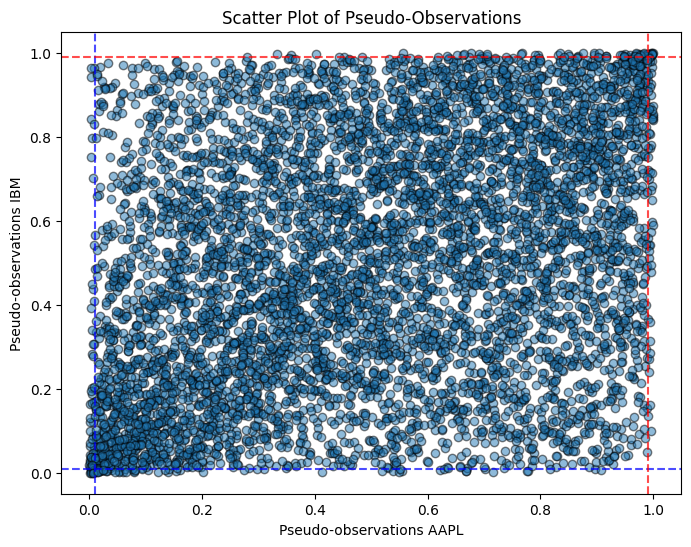

In [38]:
plt.figure(figsize=(8, 6))

# Scatter plot of pseudo-observations
plt.scatter(ps_obs_ecdf[:, 0], ps_obs_ecdf[:, 1], alpha=0.5, edgecolors='k')
# Lower tail (0.01) - Blue lines
plt.axhline(0.01, color='blue', linestyle='--', alpha=0.7, label='Lower tail (0.01)')
plt.axvline(0.01, color='blue', linestyle='--', alpha=0.7)

# Upper tail (0.99) - Red lines
plt.axhline(0.99, color='red', linestyle='--', alpha=0.7, label='Upper tail (0.99)')
plt.axvline(0.99, color='red', linestyle='--', alpha=0.7)

# Labels and title
plt.title('Scatter Plot of Pseudo-Observations')
plt.xlabel('Pseudo-observations AAPL')
plt.ylabel('Pseudo-observations IBM')

plt.show()

The scatter plot of pseudo-observations shows a clear clustering of points in both the lower-left and upper-right corners, indicating the presence of lower and upper tail dependence. The clustering is slightly denser in the upper-right corner, which is consistent with the empirical estimates showing stronger upper tail dependence (0.1663) compared to the lower tail (0.1399). These visual patterns support the conclusion that AAPL and IBM exhibit moderate but asymmetric tail dependence in their joint return behaviour.

The t-copula assumes symmetric tail dependence, and the relatively low tail dependence value of 0.0683 suggests a weaker joint occurrence of extreme returns than what is visually evident in the data. This suggests that while the t-copula captures some degree of tail dependence, it appears to underestimate the strength and asymmetry present in the historical data — potentially making it less suitable for modeling joint extreme events in this case. In contrast, the scatter plot reveals more frequent co-movement in extreme values, especially in the upper tail, which aligns better with the empirical estimates.

**Task 4.2.3.3 - Monte Carlo VaR/ES with the Student’s t copula**

In [39]:
#set up parameters

n_sim = 10000
mean_10d_log_return_aapl = df['AAPL_10d_log_return'].mean()
mean_10d_log_return_ibm = df['IBM_10d_log_return'].mean()

aapl_std = np.sqrt(ewma_log_ret_cov[0,0])
ibm_std = np.sqrt(ewma_log_ret_cov[1,1])

In [40]:
from scipy.stats import multivariate_t

np.random.seed(10) # for reproducibility

# Generate random numbers from bivariate t-distribution (use parameters from MLE)
mult_t_sim = stats.multivariate_t.rvs(loc=None, shape=tcop_cov, df=nu, size=n_sim)

# Transform to uniform variables using the univariate t-CDF
tcop_sim = stats.t.cdf(mult_t_sim, df=nu)

In [41]:
# Apply quantile transform to generate simulated log-returns
aapl_logret_tcop_sim = stats.norm.ppf(tcop_sim[:,0], loc = mean_10d_log_return_aapl, scale = aapl_std)
ibm_logret_tcop_sim = stats.norm.ppf(tcop_sim[:,1], loc = mean_10d_log_return_ibm, scale = ibm_std)

# Simulated risk factor changes scenarios - combine into a single numpy array
df_sim_tcop = np.column_stack([aapl_logret_tcop_sim, ibm_logret_tcop_sim])

In [42]:
#construct loss_scenarios (simulated losses)

loss_scenarios_tcop = - scaledportfoliotheta - np.matmul(df_sim_tcop, portfolio_exposure) - 0.5 * np.diag(np.matmul(df_sim_tcop, np.matmul(portfoliogammaexposure, df_sim_tcop.T)))

In [43]:
# OR, use the below (both give the same results)

# Loss scenarios - for-loop approach
loss_scenarios_mc_dg_tcop = np.zeros(len(df_sim_tcop))

for i in range(len(df_sim_tcop)):
        loss_scenarios_mc_dg_tcop[i] = - scaledportfoliotheta - np.matmul(df_sim_tcop[i,:], portfolio_exposure) - 0.5 * np.matmul(df_sim_tcop[i,:], np.matmul(portfoliogammaexposure, df_sim_tcop[i,:].T))

In [44]:
# Calculate risk measures empirical loss distribution
rm_mc_dg_tcop = VaR_ES_emp(loss_scenarios_mc_dg_tcop, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR under t Cop MC : {rm_mc_dg_tcop[0]:.4f}")
print(f"10 day 99% Portfolio ES under t Cop MC: {rm_mc_dg_tcop[1]:.4f}")

10 day 99% Portfolio VaR under t Cop MC : 22.6810
10 day 99% Portfolio ES under t Cop MC: 24.5951


In [45]:
# full valuation t cop MC approach

# Risk factor scenarios
aapl_price_scenarios = AAPLprice * np.exp(aapl_logret_tcop_sim)
ibm_price_scenarios = IBMprice * np.exp(ibm_logret_tcop_sim)

# Option price scenarios
aapl_call_scenarios = BSprice(aapl_price_scenarios, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
ibm_call_scenarios = BSprice(ibm_price_scenarios, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

In [46]:
# Portfolio loss scenarios
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios2 = aapl_call_scenarios + ibm_call_scenarios - 1*aapl_price_scenarios - 1*ibm_price_scenarios
loss_scenarios_fv2 = -(portfolio_scenarios2 - portfolio_value)

# Calculate risk measures using FV standard historical simulation
rm_hs_fvMC = VaR_ES_emp(loss_scenarios_fv2, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR under t Cop FV MC : {rm_hs_fvMC[0]:.4f}")
print(f"10 day 99% Portfolio ES under t Cop FV MC:  {rm_hs_fvMC[1]:.4f}")

10 day 99% Portfolio VaR under t Cop FV MC : 22.5129
10 day 99% Portfolio ES under t Cop FV MC:  24.3889


**Comparing t Cop MC to the delta gamma approximation**

Analytical DG approximation for VaR and ES for portfolio:
[23.6119 26.5496]

Under t Cop MC under empirical distribution for simulated losses, VaR and ES for portfolio:
[22.6810 24.5951]

Under t Cop FV MC, VaR and ES for portfolio
[22.5129 and 24.3889]

The delta-gamma approximation produces larger calculations for the 99% Portfolio VaR and ES vs. both forms of MC estimation under the Student t copula. This is because the DG approximation uses a second-order Taylor expansion to estimate portfolio losses, which can overstate tail risk due to the quadratic term. The t-copula MC method with delta-gamma lowers these estimates by simulating risk factor scenarios with realistic tail dependence and better capturing joint extreme events, but still relies on the same approximate loss function. The t cop FV MC is the most refined approach and produces the lowest risk estimates, as it captures both the tail dependence in risk factors and also the nonlinear behaviour of the portfolio through revaluing the portfolio over various historical scenarios, and would be our preferred method of measuring risk in this situation.


**Task 4.2.3.4 - Monte Carlo VaR/ES with bivariate Gaussian distribution**

In [47]:
# construct normal random variables

from scipy.stats import multivariate_normal

mean_vector = np.array([mean_10d_log_return_aapl, mean_10d_log_return_ibm])
ewma_log_ret_cov

np.random.seed(10)
mult_bivarnorm_sim = stats.multivariate_normal.rvs(mean=mean_vector, cov=ewma_log_ret_cov, size=n_sim) # using the mean vector and previously calculated EWMA covariance matrix. Gen AI reference is below.

In [48]:
aapl_bivarnorm_sim = mult_bivarnorm_sim[:,0]
ibm_bivarnorm_sim = mult_bivarnorm_sim[:,1]

df_sim_bivarnorm = np.column_stack([aapl_bivarnorm_sim, ibm_bivarnorm_sim])

In [49]:
#using DG approximation
loss_scenarios_bivarnorm = - scaledportfoliotheta - np.matmul(df_sim_bivarnorm, portfolio_exposure) - 0.5 * np.diag(np.matmul(df_sim_bivarnorm, np.matmul(portfoliogammaexposure, df_sim_bivarnorm.T)))

In [50]:
# OR (get the same output)

# Loss scenarios - for-loop approach
loss_scenarios_mc_dg_bivarnorm = np.zeros(len(df_sim_bivarnorm))

for i in range(len(df_sim_bivarnorm)):
        loss_scenarios_mc_dg_bivarnorm[i] = - scaledportfoliotheta - np.matmul(df_sim_bivarnorm[i,:], portfolio_exposure) - 0.5 * np.matmul(df_sim_bivarnorm[i,:], np.matmul(portfoliogammaexposure, df_sim_bivarnorm[i,:].T))


In [51]:
# Calculate risk measures empirical loss distribution
rm_mc_dg_bivarnorm = VaR_ES_emp(loss_scenarios_mc_dg_bivarnorm, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR under MC using bivariate normal dist: {rm_mc_dg_bivarnorm[0]:.4f}")
print(f"10 day 99% Portfolio ES under MC using bivariate normal dist: {rm_mc_dg_bivarnorm[1]:.4f}")

10 day 99% Portfolio VaR under MC using bivariate normal dist: 19.0894
10 day 99% Portfolio ES under MC using bivariate normal dist: 20.7407


In [52]:
## full valuation approach

# Convert to future prices using simulated log-returns
aapl_price_norm_scenarios = AAPLprice * np.exp(aapl_bivarnorm_sim)
ibm_price_norm_scenarios = IBMprice * np.exp(ibm_bivarnorm_sim)

# Recompute option prices
aapl_call_norm_scenarios = BSprice(aapl_price_norm_scenarios, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
ibm_call_norm_scenarios = BSprice(ibm_price_norm_scenarios, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Full portfolio revaluation
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_norm = aapl_call_norm_scenarios + ibm_call_norm_scenarios - 1*aapl_price_norm_scenarios - 1*ibm_price_norm_scenarios
loss_scenarios_bivarnorm_fv = -(portfolio_scenarios_norm - portfolio_value)


In [53]:
# Calculate risk measures using FV standard historical simulation
rm_hs_norm_fvMC = VaR_ES_emp(loss_scenarios_bivarnorm_fv, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR under FV MC using bivariate normal dist: {rm_hs_norm_fvMC[0]:.4f}")
print(f"10 day 99% Portfolio ES under FV MC using bivariate normal dist: {rm_hs_norm_fvMC[1]:.4f}")

10 day 99% Portfolio VaR under FV MC using bivariate normal dist: 18.9928
10 day 99% Portfolio ES under FV MC using bivariate normal dist: 20.5839


**Task 4.2.3.5 - Comparison of Risk Measures (t-Copula vs. Joint Gaussian)**

Based on the Monte Carlo simulations:

*   **t-Copula :**
    *   Portfolio VaR and ES: { 22.6180  24.5951 }

*   **Joint Gaussian Distribution :**
    *   Portfolio VaR and ES: { 19.08940  20.7407 }

And under the FV approach:

*   **t-Copula:**
    *   Portfolio VaR and ES: { 22.5129  24.3889 }
  
*   **Joint Gaussian Distribution:**
    *   Portfolio VaR and ES: { 18.9928 20.5839 }


Comparing these values, the VaR and ES estimates under the t-copula assumption are higher than those under the joint Gaussian distribution assumption in both the standard MC and FV MC case. The differences in these values can be attributed to the contrasting tail behaviour between the Student's t distribution (which underlies the t-copula) and the Gaussian (Normal) distribution.

1.  **Tail Thickness:** The Student's t distribution has fatter tails than the Normal distribution. This means that extreme events (large positive or negative returns) are more probable under a t-distribution assumption than under a Normal distribution assumption.

2.  **Tail Dependence:** As we observed in the analysis of pseudo-observations and the calculated tail dependence coefficients, the historical data shows evidence of tail dependence. This means that extreme movements in one asset's returns are associated with extreme movements in the other asset's returns. The bivariate Normal distribution, on the other hand, assumes tail independence, meaning that extreme events in one variable are independent of extreme events in the other when conditioned on being in the tail.

**Why the Results are Different:**

The higher VaR and ES values obtained under the t-copula assumption are a direct consequence of its fatter tails and ability to model tail dependence. In a t-copula simulation, co-extreme events (both assets experiencing large negative returns simultaneously) occur more frequently than in a joint Gaussian simulation. Since VaR and ES are measures of risk associated with extreme losses, the increased likelihood of simultaneous large losses under the t-copula leads to higher estimates of potential extreme losses. The Gaussian model, by assuming tail independence, underestimates the probability of these joint extreme events and thus produces lower risk measures.

**Which Joint Model May Be More Appropriate:**

Given the empirical evidence of tail dependence in the historical log return data (as seen in the scatter plot of pseudo-observations and supported by the non-zero empirical tail dependence coefficients), the **bivariate Student's t copula** is likely a **more appropriate** joint model for this data than the joint Gaussian distribution.

The t-copula's ability to capture the observed tail dependence is crucial for accurately modeling the risk of a portfolio, especially in periods of market stress when assets tend to exhibit stronger co-movements in their tails. Relying on a joint Gaussian assumption (which implies tail independence) could lead to an underestimation of portfolio risk.

Therefore, based on the characteristics of the data and the properties of the distributions, the t-copula provides a more realistic representation of the joint behaviour of the log returns during extreme market movements, leading to more conservative and potentially more accurate risk estimates.

# **Section 4.3 - Stressed VaR and ES Calculations**

**Task 4.3.1**

In [54]:
# define 1st stressed period - GFC. Use GFC and Stressed Period 1 interchangably
gfc_df = df.loc["2007-12-03":"2009-06-30"]

# Mean and covariance of stressed risk factor changes (sample)
gfc_df_mean = gfc_df.mean(axis = 0)
gfc_df_cov_samp = gfc_df.cov()

# Portfolio-level stressed VaR and ES. Only considering delta-loss here!
stressed_rm_analytical_gfc = VaR_ES_vcv(scaledportfoliotheta, portfolio_exposure, gfc_df_mean, gfc_df_cov_samp, conf_level)

var_analytical_gfc, es_analytical_gfc = stressed_rm_analytical_gfc

print(f"10 day 99% Portfolio VaR during GFC: {var_analytical_gfc:.4f}")
print(f"10 day 99% Portfolio ES during GFC: {es_analytical_gfc:.4f}")

10 day 99% Portfolio VaR during GFC: 37.4988
10 day 99% Portfolio ES during GFC: 42.6964


In [55]:
#define 2nd stressed period - COVID. Use COVID and Stressed Period 2 interchangably

covid_df = df.loc["2020-01-30":"2021-02-01"]
covid_df_mean = covid_df.mean(axis = 0)
covid_df_cov_samp = covid_df.cov()

# Portfolio-level stressed VaR and ES during COVID
stressed_rm_analytical_covid = VaR_ES_vcv(scaledportfoliotheta, portfolio_exposure, covid_df_mean, covid_df_cov_samp, conf_level)

var_analytical_covid, es_analytical_covid = stressed_rm_analytical_covid

print(f"10 day 99% Portfolio VaR during COVID using analytical method: {var_analytical_covid:.4f}")
print(f"10 day 99% Portfolio ES during COVID using analytical method: {es_analytical_covid:.4f}")

10 day 99% Portfolio VaR during COVID using analytical method: 36.4899
10 day 99% Portfolio ES during COVID using analytical method: 41.1845


**Task 4.3.2**

In [56]:
#HISTORICAL SIM - GFC

# Risk factor scenarios
AAPL_gfc_price_scenarios = AAPLprice * np.exp(gfc_df['AAPL_10d_log_return'])
IBM_gfc_price_scenarios = IBMprice * np.exp(gfc_df['IBM_10d_log_return'])

# Option price scenarios
AAPL_gfc_call_scenarios = BSprice(AAPL_gfc_price_scenarios, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
IBM_gfc_call_scenarios = BSprice(IBM_gfc_price_scenarios, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Portfolio loss scenarios
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_gfc = AAPL_gfc_call_scenarios + IBM_gfc_call_scenarios - 1*AAPL_gfc_price_scenarios - 1*IBM_gfc_price_scenarios
loss_scenarios_fv_gfc = -(portfolio_scenarios_gfc - portfolio_value)

# Calculate risk measures empirical loss distribution
rm_stressed_hs_fv_gfc = VaR_ES_emp(loss_scenarios_fv_gfc, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR during GFC using standard HS: {rm_stressed_hs_fv_gfc[0]:.4f}")
print(f"10 day 99% Portfolio ES during GFC using standard HS: {rm_stressed_hs_fv_gfc[1]:.4f}")

10 day 99% Portfolio VaR during GFC using standard HS: 22.4713
10 day 99% Portfolio ES during GFC using standard HS: 23.6675


In [57]:
#HISTORICAL SIM - COVID

# Risk factor scenarios
AAPL_covid_price_scenarios = AAPLprice * np.exp(covid_df['AAPL_10d_log_return'])
IBM_covid_price_scenarios = IBMprice * np.exp(covid_df['IBM_10d_log_return'])

# Option price scenarios
AAPL_covid_call_scenarios = BSprice(AAPL_covid_price_scenarios, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
IBM_covid_call_scenarios = BSprice(IBM_covid_price_scenarios, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Portfolio loss scenarios
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_covid = AAPL_covid_call_scenarios + IBM_covid_call_scenarios - 1*AAPL_covid_price_scenarios - 1*IBM_covid_price_scenarios
loss_scenarios_fv_covid = -(portfolio_scenarios_covid - portfolio_value)

# Calculate risk measures empirical loss distribution
rm_stressed_hs_fv_covid = VaR_ES_emp(loss_scenarios_fv_covid, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR during COVID using standard HS: {rm_stressed_hs_fv_covid[0]:.4f}")
print(f"10 day 99% Portfolio ES during COVID using standard HS: {rm_stressed_hs_fv_covid[1]:.4f}")

10 day 99% Portfolio VaR during COVID using standard HS: 20.6504
10 day 99% Portfolio ES during COVID using standard HS: 23.2192


**Task 4.3.3 - t Cop MC during both stressed periods**

In [58]:
## gfc means/sd for later

AAPL_gfc_mean = gfc_df['AAPL_10d_log_return'].mean()
IBM_gfc_mean = gfc_df['IBM_10d_log_return'].mean()

aapl_std_gfc = gfc_df['AAPL_10d_log_return'].std()
ibm_std_gfc = gfc_df['IBM_10d_log_return'].std()

In [59]:
# Estimate the parameters of the t copula
log_ret_stressed_rank_gfc = stats.rankdata(gfc_df[['AAPL_10d_log_return', 'IBM_10d_log_return']], axis = 0)
ps_obs_aapl_gfc = log_ret_stressed_rank_gfc[:,0] / (len(gfc_df) + 1)
ps_obs_ibm_gfc = log_ret_stressed_rank_gfc[:,1] / (len(gfc_df) + 1)

# Function for the negative log-likelihood of the t copula
def neg_loglik_t(pars, u, v):
    # Parameters for the multivariate t distribution
    nu = pars[0]
    rho = pars[1]
    cov_mat = [[1, rho], [rho, 1]]

    # Compute the inverse of the univariate cdf at the pseudo-observations
    F_inv1 = stats.t.ppf(u, df = nu)
    F_inv2 = stats.t.ppf(v, df = nu)

    # Calculate the log-likelihood
    numerator = stats.multivariate_t.pdf(np.array([F_inv1, F_inv2]).T, loc = None, shape = cov_mat, df = nu, allow_singular = False)
    denominator = stats.t.pdf(F_inv1, df = nu) * stats.t.pdf(F_inv2, df = nu)

    ratio = numerator / denominator
    ratio = ratio[~np.isnan(ratio)]    # In case the process above generates NaNs

    value = -np.sum(np.log(ratio))
    return value

# Find MLE estimates of t copula
init_pars = [2, 0.1]
bnds = ((0, None), (-0.999999, 0.999999))
tcop_emp_pars_gfc = optimize.minimize(neg_loglik_t, init_pars, args = (ps_obs_aapl_gfc, ps_obs_ibm_gfc), bounds = bnds)

# Extract outputs
tcop_emp_df_gfc = tcop_emp_pars_gfc.x[0]
tcop_emp_rho_gfc = tcop_emp_pars_gfc.x[1]
tcop_emp_cov_gfc = [[1, tcop_emp_rho_gfc], [tcop_emp_rho_gfc, 1]]


In [60]:
print(f"t copula df GFC: {tcop_emp_df_gfc:.4f}")
print(f"t copula rho GFC: {tcop_emp_rho_gfc:.4f}")

t copula df GFC: 2.8735
t copula rho GFC: 0.5100


In [61]:
tcop_emp_pars_gfc = optimize.minimize(neg_loglik_t, init_pars, args = (ps_obs_aapl_gfc, ps_obs_ibm_gfc), bounds = bnds)
#tcop_emp_pars_gfc.success
#tcop_emp_pars_gfc.message

In [62]:
## GFC MC now

nu_gfc = tcop_emp_df_gfc
rho_gfc = tcop_emp_rho_gfc

from scipy.stats import multivariate_t

np.random.seed(10)
# Generate random numbers from bivariate t-distribution
mult_t_sim_gfc = stats.multivariate_t.rvs(loc=None, shape=tcop_emp_cov_gfc, df=nu_gfc, size=n_sim)

# Transform to uniform variables using the univariate t-CDF
tcop_sim_gfc = stats.t.cdf(mult_t_sim_gfc, df=nu_gfc)

In [63]:
## - Apply quantile transform to generate simulated log-returns
aapl_logret_tcop_sim_gfc = stats.norm.ppf(tcop_sim_gfc[:,0], loc = AAPL_gfc_mean, scale = aapl_std_gfc)
ibm_logret_tcop_sim_gfc = stats.norm.ppf(tcop_sim_gfc[:,1], loc = IBM_gfc_mean, scale = ibm_std_gfc)

# Simulated risk factor changes scenarios - combine into a single numpy array
df_sim_tcop_gfc = np.column_stack([aapl_logret_tcop_sim_gfc, ibm_logret_tcop_sim_gfc])

In [64]:
# Risk factor scenarios
aapl_price_scenarios_tcop_gfc = AAPLprice * np.exp(aapl_logret_tcop_sim_gfc)
ibm_price_scenarios_tcop_gfc = IBMprice * np.exp(ibm_logret_tcop_sim_gfc)

# Option price scenarios
aapl_call_scenarios_tcop_gfc = BSprice(aapl_price_scenarios_tcop_gfc, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
ibm_call_scenarios_tcop_gfc = BSprice(ibm_price_scenarios_tcop_gfc, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Portfolio loss scenarios
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_gfc1 = aapl_call_scenarios_tcop_gfc + ibm_call_scenarios_tcop_gfc - 1*aapl_price_scenarios_tcop_gfc - 1*ibm_price_scenarios_tcop_gfc
loss_scenarios_stressed_mc_fv_gfc = -(portfolio_scenarios_gfc1 - portfolio_value)

# Calculate risk measures empirical loss distribution
rm_stressed_mc_fv_gfc = VaR_ES_emp(loss_scenarios_stressed_mc_fv_gfc, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR during GFC using t Cop MC: {rm_stressed_mc_fv_gfc[0]:.4f}")
print(f"10 day 99% Portfolio ES during GFC using t Cop MC: {rm_stressed_mc_fv_gfc[1]:.4f}")

10 day 99% Portfolio VaR during GFC using t Cop MC: 23.5742
10 day 99% Portfolio ES during GFC using t Cop MC: 25.2155


In [65]:
## moving onto stressed period 2 , COVID
## COVID means
AAPL_covid_mean = covid_df['AAPL_10d_log_return'].mean()
IBM_covid_mean = covid_df['IBM_10d_log_return'].mean()

aapl_std_covid = covid_df['AAPL_10d_log_return'].std()
ibm_std_covid = covid_df['IBM_10d_log_return'].std()

In [66]:
# Estimate the parameters of the t copula
log_ret_stressed_rank_covid = stats.rankdata(covid_df[['AAPL_10d_log_return', 'IBM_10d_log_return']], axis = 0)
ps_obs_aapl_covid = log_ret_stressed_rank_covid[:,0] / (len(covid_df) + 1)
ps_obs_ibm_covid = log_ret_stressed_rank_covid[:,1] / (len(covid_df) + 1)

# Function for the negative log-likelihood of the t copula
def neg_loglik_t(pars, u, v):
    # Parameters for the multivariate t distribution
    nu = pars[0]
    rho = pars[1]
    cov_mat = [[1, rho], [rho, 1]]

    # Compute the inverse of the univariate cdf at the pseudo-observations
    F_inv1 = stats.t.ppf(u, df = nu)
    F_inv2 = stats.t.ppf(v, df = nu)

    # Calculate the log-likelihood
    numerator = stats.multivariate_t.pdf(np.array([F_inv1, F_inv2]).T, loc = None, shape = cov_mat, df = nu, allow_singular = False)
    denominator = stats.t.pdf(F_inv1, df = nu) * stats.t.pdf(F_inv2, df = nu)

    ratio = numerator / denominator
    ratio = ratio[~np.isnan(ratio)]    # In case the process above generates NaNs

    value = -np.sum(np.log(ratio))
    return value

# Find MLE estimates of t copula
init_pars = [2, 0.1]
bnds = ((0, None), (-0.999999, 0.999999))
tcop_emp_pars_covid = optimize.minimize(neg_loglik_t, init_pars, args = (ps_obs_aapl_covid, ps_obs_ibm_covid), bounds = bnds)

# Extract outputs
tcop_emp_df_covid = tcop_emp_pars_covid.x[0]
tcop_emp_rho_covid = tcop_emp_pars_covid.x[1]
tcop_emp_cov_covid = [[1, tcop_emp_rho_covid], [tcop_emp_rho_covid, 1]]

In [67]:
print(f"t copula df COVID: {tcop_emp_df_covid:.4f}")
print(f"t copula rho COVID: {tcop_emp_rho_covid:.4f}")

t copula df COVID: 31.5582
t copula rho COVID: 0.3539


In [68]:
tcop_emp_pars_covid = optimize.minimize(neg_loglik_t, init_pars, args = (ps_obs_aapl_covid, ps_obs_ibm_covid), bounds = bnds)

In [69]:
## COVID MC now

nu_covid = tcop_emp_df_covid
rho_covid = tcop_emp_rho_covid

from scipy.stats import multivariate_t

np.random.seed(10)
# Generate random numbers from bivariate t-distribution
mult_t_sim_covid = stats.multivariate_t.rvs(loc=None, shape=tcop_emp_cov_covid, df=nu_covid, size=n_sim)

# Transform to uniform variables using the univariate t-CDF
tcop_sim_covid = stats.t.cdf(mult_t_sim_covid, df=nu_covid)

In [70]:
## - Apply quantile transform to generate simulated log-returns
aapl_logret_tcop_sim_covid = stats.norm.ppf(tcop_sim_covid[:,0], loc = AAPL_covid_mean, scale = aapl_std_covid)
ibm_logret_tcop_sim_covid = stats.norm.ppf(tcop_sim_covid[:,1], loc = IBM_covid_mean, scale = ibm_std_covid)

# Simulated risk factor changes scenarios - combine into a single numpy array
df_sim_tcop_covid = np.column_stack([aapl_logret_tcop_sim_covid, ibm_logret_tcop_sim_covid])

In [72]:
# Risk factor scenarios
aapl_price_scenarios_tcop_covid = AAPLprice * np.exp(aapl_logret_tcop_sim_covid)
ibm_price_scenarios_tcop_covid = IBMprice * np.exp(ibm_logret_tcop_sim_covid)

# Option price scenarios
aapl_call_scenarios_tcop_covid = BSprice(aapl_price_scenarios_tcop_covid, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
ibm_call_scenarios_tcop_covid = BSprice(ibm_price_scenarios_tcop_covid, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Portfolio loss scenarios
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_covid1 = aapl_call_scenarios_tcop_covid + ibm_call_scenarios_tcop_covid - 1*aapl_price_scenarios_tcop_covid - 1*ibm_price_scenarios_tcop_covid
loss_scenarios_stressed_mc_fv_covid = -(portfolio_scenarios_covid1 - portfolio_value)

# Calculate risk measures empirical loss distribution
rm_stressed_mc_fv_covid = VaR_ES_emp(loss_scenarios_stressed_mc_fv_covid, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR during COVID using t Cop MC: {rm_stressed_mc_fv_covid[0]:.4f}")
print(f"10 day 99% Portfolio ES during COVID using t Cop MC: {rm_stressed_mc_fv_covid[1]:.4f}")

10 day 99% Portfolio VaR during COVID using t Cop MC: 24.1609
10 day 99% Portfolio ES during COVID using t Cop MC: 25.6047


**Task 4.3.4 - MC using bivariate Gaussian dist**

In [73]:
## bivariate normal - GFC (stressed period 1)

from scipy.stats import multivariate_normal

gfc_df_mean = gfc_df.mean(axis = 0)
gfc_df_cov_samp = gfc_df.cov()

np.random.seed(10)

mult_bivarnorm_sim_gfc = stats.multivariate_normal.rvs(mean=gfc_df_mean, cov=gfc_df_cov_samp, size=n_sim)

In [74]:
aapl_bivarnorm_sim_gfc = mult_bivarnorm_sim_gfc[:,0]
ibm_bivarnorm_sim_gfc = mult_bivarnorm_sim_gfc[:,1]

df_sim_bivarnorm_gfc = np.column_stack([aapl_bivarnorm_sim_gfc, ibm_bivarnorm_sim_gfc])

In [75]:
## full valuation approach

# Convert to future prices using simulated log-returns
aapl_price_norm_scenarios_gfc = AAPLprice * np.exp(aapl_bivarnorm_sim_gfc)
ibm_price_norm_scenarios_gfc = IBMprice * np.exp(ibm_bivarnorm_sim_gfc)

# Recompute option prices
aapl_call_norm_scenarios_gfc = BSprice(aapl_price_norm_scenarios_gfc, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
ibm_call_norm_scenarios_gfc = BSprice(ibm_price_norm_scenarios_gfc, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Full portfolio revaluation
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_norm_gfc = aapl_call_norm_scenarios_gfc + ibm_call_norm_scenarios_gfc - 1*aapl_price_norm_scenarios_gfc - 1*ibm_price_norm_scenarios_gfc
loss_scenarios_bivarnorm_fv_gfc = -(portfolio_scenarios_norm_gfc - portfolio_value)

# Calculate risk measures using FV MC
rm_hs_norm_fvMC_gfc = VaR_ES_emp(loss_scenarios_bivarnorm_fv_gfc, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR during GFC using bivariate norm MC: {rm_hs_norm_fvMC_gfc[0]:.4f}")
print(f"10 day 99% Portfolio ES during GFC using bivariate norm MC: {rm_hs_norm_fvMC_gfc[1]:.4f}")

10 day 99% Portfolio VaR during GFC using bivariate norm MC: 23.3772
10 day 99% Portfolio ES during GFC using bivariate norm MC: 24.7803


In [76]:
##bivariate normal - COVID (stressed period 2)

from scipy.stats import multivariate_normal

np.random.seed(10)

mult_bivarnorm_sim_covid = stats.multivariate_normal.rvs(mean=covid_df_mean, cov=covid_df_cov_samp, size=n_sim)

In [77]:
aapl_bivarnorm_sim_covid = mult_bivarnorm_sim_covid[:,0]
ibm_bivarnorm_sim_covid = mult_bivarnorm_sim_covid[:,1]

df_sim_bivarnorm_covid = np.column_stack([aapl_bivarnorm_sim_covid, ibm_bivarnorm_sim_covid])

In [78]:
## full valuation approach

# Convert to future prices using simulated log-returns
aapl_price_norm_scenarios_covid = AAPLprice * np.exp(aapl_bivarnorm_sim_covid)
ibm_price_norm_scenarios_covid = IBMprice * np.exp(ibm_bivarnorm_sim_covid)

# Recompute option prices
aapl_call_norm_scenarios_covid = BSprice(aapl_price_norm_scenarios_covid, AAPLprice, 3/12 - delta_t, r_f, 0, AAPL_ann_vol, 'call')
ibm_call_norm_scenarios_covid = BSprice(ibm_price_norm_scenarios_covid, IBMprice, 6/12 - delta_t, r_f, 0, IBM_ann_vol, 'call')

# Full portfolio revaluation
portfolio_value = AAPLcall + IBMcall - 1*AAPLprice - 1*IBMprice
portfolio_scenarios_norm_covid = aapl_call_norm_scenarios_covid + ibm_call_norm_scenarios_covid - 1*aapl_price_norm_scenarios_covid - 1*ibm_price_norm_scenarios_covid
loss_scenarios_bivarnorm_fv_covid = -(portfolio_scenarios_norm_covid - portfolio_value)

# Calculate risk measures using FV MC
rm_hs_norm_fvMC_covid = VaR_ES_emp(loss_scenarios_bivarnorm_fv_covid, conf_level = conf_level, hs_weight_type = "equal")

print(f"10 day 99% Portfolio VaR during COVID using bivariate norm MC: {rm_hs_norm_fvMC_covid[0]:.4f}")
print(f"10 day 99% Portfolio ES during COVID using bivariate norm MC: {rm_hs_norm_fvMC_covid[1]:.4f}")

10 day 99% Portfolio VaR during COVID using bivariate norm MC: 24.8895
10 day 99% Portfolio ES during COVID using bivariate norm MC: 26.6780


**Task 4.3.5**

In [79]:
import pandas as pd
import numpy as np

# Define MultiIndex for columns
columns = pd.MultiIndex.from_tuples([
    ("Method", ""),
    ("Stress Period 1 (GFC)", "VaR"),
    ("Stress Period 1 (GFC)", "ES"),
    ("Stress Period 2 (COVID)", "VaR"),
    ("Stress Period 2 (COVID)", "ES")
])

# Sample data (can replace None or np.nan with real values)
data = [
    ["Analytical", stressed_rm_analytical_gfc[0], stressed_rm_analytical_gfc[1], stressed_rm_analytical_covid[0], stressed_rm_analytical_covid[1]],
    ["Standard Historical Simulation", rm_stressed_hs_fv_gfc[0], rm_stressed_hs_fv_gfc[1], rm_stressed_hs_fv_covid[0], rm_stressed_hs_fv_covid[1]],
    ["Monte Carlo Simulation (t Copula)", rm_stressed_mc_fv_gfc[0], rm_stressed_mc_fv_gfc[1], rm_stressed_mc_fv_covid[0], rm_stressed_mc_fv_gfc[1]],
    ["Monte Carlo Simulation (Gaussian)", rm_hs_norm_fvMC_gfc[0], rm_hs_norm_fvMC_gfc[1], rm_hs_norm_fvMC_covid[0], rm_hs_norm_fvMC_covid[1]]
]

# Create the DataFrame
df4_3_5 = pd.DataFrame(data, columns=columns)

# Round numeric values to 4 decimals and print
df4_3_5_rounded = df4_3_5.round(4)
print("TABLE 1")
df4_3_5_rounded


TABLE 1


Method Stress Period 1 (GFC)           \
                                                       VaR       ES   
0                         Analytical               37.4988  42.6964   
1     Standard Historical Simulation               22.4713  23.6675   
2  Monte Carlo Simulation (t Copula)               23.5742  25.2155   
3  Monte Carlo Simulation (Gaussian)               23.3772  24.7803   

  Stress Period 2 (COVID)           
                      VaR       ES  
0                 36.4899  41.1845  
1                 20.6504  23.2192  
2                 24.1609  25.2155  
3                 24.8895  26.6780

**Comparison of Risk Measures: Stressed Periods vs. Full Historical Data from 4.2**

Let's compare the risk measures obtained from the stressed periods (GFC and COVID) with those obtained from the full historical data in Section 4.2.

| Method                              | Full Data VaR | Full Data ES | GFC VaR | GFC ES | COVID VaR | COVID ES |
|-------------------------------------|---------------|--------------|---------|--------|-----------|----------|
| Analytical (Delta-only)             | 23.6119       | 26.5496      | 37.4988 | 42.6964| 36.4899   | 41.1845  |
| Standard HS (Full Valuation)        | 19.9890       | 23.1564      | 22.4713 | 23.6675| 20.6504   | 23.2192  |
| Age-Weighted HS (Full Valuation)    | 12.0524       | 13.2682      | N/A     | N/A    | N/A       | N/A      |
| MC (t Copula, Full Valuation)       | 22.5129       | 24.3889      | 23.5742 | 25.2155| 24.1609   | 25.6047  |
| MC (Gaussian, Full Valuation)       | 18.9928       | 20.5839      | 23.3772 | 24.7803| 24.8895   | 26.6780  |

*(Note: Age-Weighted HS was not calculated for stressed periods in the notebook.)*

**Discussion on Appropriateness of Stressed Period Measures as Stressed Risk Measure Estimates:**

Based on the comparison, the risk measures (VaR and ES) calculated using data from the stressed periods (GFC and COVID) are generally **higher** than those calculated using the full historical data period. This is particularly evident in the Analytical and Monte Carlo methods.

**Why are the stressed period measures higher?**

Stressed periods like the GFC and COVID-19 pandemic were characterized by significantly higher market volatility and larger, more frequent extreme price movements compared to the entire historical dataset. When you calculate risk measures using data from these periods, you are capturing the distribution of returns and losses during times of market stress. This distribution typically has fatter tails and higher dispersion, leading to larger estimates of potential extreme losses (VaR and ES).

**Is it appropriate to use the risk measures summarized in Table 1 as stressed risk measure estimates?**

Yes, it is appropriate to use the risk measures calculated using data from identified stressed periods as stressed risk measure estimates. Here's why:

*   **Regulatory Requirements:** Regulatory frameworks (like Basel III and APRA APS 116) often require financial institutions to calculate stressed VaR and stressed ES using historical data from a period of significant financial stress relevant to the institution's portfolio. This is to ensure that firms hold sufficient capital to cover potential losses during adverse market conditions.
*   **Capturing Tail Risk:** Stressed periods provide real-world examples of how portfolios behave under extreme market movements and heightened correlations. Using data from these periods allows for the estimation of risk measures that are more representative of potential losses during future crises than measures based on calmer periods.
*   **Forward-Looking Perspective:** While based on historical data, stressed risk measures are intended to provide a forward-looking perspective on potential losses in a stressed market environment. By using data from past crises, we are essentially simulating the impact of a similar future event on the current portfolio.

**However, there are considerations:**

*   **Relevance of Historical Stressed Periods:** The chosen stressed periods should be relevant to the current portfolio structure and market conditions. A crisis from decades ago might not fully reflect the risks in a portfolio today due to changes in market structure, instruments, and correlations.
*   **Methodology Sensitivity:** As seen in the table, different methodologies (Analytical, HS, MC, and the underlying distribution assumptions) produce different stressed risk estimates. The choice of methodology can significantly impact the results. Full Valuation approaches are generally preferred over approximations during stressed periods due to the increased impact of non-linearities.
*   **Portfolio Changes:** Stressed risk measures calculated using historical data assume that the current portfolio would have behaved similarly during the historical stressed period. If the portfolio composition or risk profile has changed significantly, the historical stressed measures may not be fully representative.

In conclusion, using risk measures calculated from relevant historical stressed periods is a standard and appropriate practice for estimating stressed risk. These measures provide valuable insights into potential losses during adverse market conditions and are often required for regulatory capital calculations. The higher values observed during stressed periods reflect the increased risk inherent in these turbulent times.

# **Section 4.4 - A Simple Risk Minimization Strategy**

**Task 4.4.1**

## Minimizing Risk: Delta Loss Variance

To minimize the **risk** of loss (rather than just expected value), we focus on the **variance** of the delta loss:

$$
\mathcal{L}_{\Delta, t+1} = -(\theta_{1,t} + \theta_{2,t})(\Delta_{1,t} + \Delta_{2,t})
- \left[ S_{1,t}(\Delta_{1,t} - \eta_1),\; S_{2,t}(\Delta_{2,t} - \eta_2) \right]
\begin{bmatrix}
X_{1,t+1} \\
X_{2,t+1}
\end{bmatrix}
$$

We ignore the deterministic (expectation) term and compute the variance:

$$
\text{Var}(\mathcal{L}_{\Delta, t+1}) =
\text{Var}\left(
S_{1,t}(\Delta_{1,t} - \eta_1) X_{1,t+1} +
S_{2,t}(\Delta_{2,t} - \eta_2) X_{2,t+1}
\right)
$$

Assuming $X_{1,t+1}, X_{2,t+1}$ are independent with variances $\sigma_1^2$ and $\sigma_2^2$, we have:

$$
\text{Var}(\mathcal{L}) =
S_{1,t}^2 (\Delta_{1,t} - \eta_1)^2 \sigma_1^2 +
S_{2,t}^2 (\Delta_{2,t} - \eta_2)^2 \sigma_2^2
$$

---

###  Minimize the Variance

Let:

$$
V(\Delta_1, \Delta_2) =
S_1^2 \sigma_1^2 (\Delta_1 - \eta_1)^2 +
S_2^2 \sigma_2^2 (\Delta_2 - \eta_2)^2
$$

Take partial derivatives and set them to zero:

#### Derivative w.r.t. $\Delta_1$:

$$
\frac{\partial V}{\partial \Delta_1} =
2 S_1^2 \sigma_1^2 (\Delta_1 - \eta_1) = 0
\quad \Rightarrow \quad
\boxed{\Delta_1 = \eta_1}
$$

#### Derivative w.r.t. $\Delta_2$:

$$
\frac{\partial V}{\partial \Delta_2} =
2 S_2^2 \sigma_2^2 (\Delta_2 - \eta_2) = 0
\quad \Rightarrow \quad
\boxed{\Delta_2 = \eta_2}
$$

---

### ✅ Conclusion

To minimize the **risk of loss**, we must choose:

$$
\boxed{
\Delta_{1,t} = \eta_1, \quad \Delta_{2,t} = \eta_2
}
$$

This creates a **delta-neutral** portfolio — fully hedged against first-order changes in the underlying asset prices.

In [89]:
eta1 = AAPLcall_delta
eta2 = IBMcall_delta

print(f"η₁ (= AAPL call delta): {eta1:.4f}")
print(f"η₂ (= IBM call delta): {eta2:.4f}")

η₁ (= AAPL call delta): 0.5527
η₂ (= IBM call delta): 0.5778


To minimize the risk of loss over the time horizon using the delta risk approximation, we need to set $\eta_1 = \Delta_{\text{AAPL}}$ and $\eta_2 = \Delta_{\text{IBM}}$ (keeping a short position in the underlying assets).

This choice eliminates the first-order sensitivity terms in the loss approximation by setting $b_t = 0$, making the portfolio **delta-neutral** with respect to small changes in the risk factors $z_{1,t}$ and $z_{2,t}$. Therefore, the variance is minimized at zero, and the portfolio loss reduces to the constant term $c_t = (\theta_1 + \theta_2)\Delta t$.

**Implications:** While this hedges the portfolio against small price movements in AAPL and IBM, it does **not** eliminate risks from time decay (theta), large price moves (captured by gamma and higher-order Greeks), or changes in volatility (vega), which are not included in the delta approximation).

Also, we are assuming the approximation has **no cross terms**, so each stock is hedged independently, regardless of any correlation between $X_{1,t+1}$ and $X_{2,t+1}$. In practice, deltas must be rebalanced periodically as underlying prices and sensitivities evolve.

**Task 4.4.2**

In [80]:
# Function to calculate analytical VaR based on number of shares.
def analytical_VaR_minimization(n_shares, constant_loss, risk_factor_mean, risk_factor_cov_mat, conf_level, aapl_price, ibm_price, aapl_delta, ibm_delta):

    n1, n2 = n_shares

    # Recalculate portfolio exposure based on the input number of shares
    portfolio_exposure_opt = np.array([
        (aapl_delta - n1) * aapl_price,
        (ibm_delta - n2) * ibm_price
    ])

    # Compute mean and variance of loss (using the delta approximation)
    # So we will use the formula from VaR_ES_vcv function, which assumes L = -c - b.T @ X
    loss_mean = -constant_loss - np.transpose(portfolio_exposure_opt) @ risk_factor_mean
    loss_var = np.transpose(portfolio_exposure_opt) @ risk_factor_cov_mat @ portfolio_exposure_opt

    # Compute VaR
    VaR = loss_mean + np.sqrt(loss_var) * stats.norm.ppf(conf_level, loc = 0.0, scale = 1.0)

    return VaR

In [81]:
# Numerically minimize the analytical 10-day 99% VaR with respect to eta1 and eta2

# Initial guess for η1 and η₂
# Based on the previous task's discussion, we expect n1 to be close to AAPLcall_delta and n2 to be close to IBMcall_delta for minimization
initial_n_shares = [AAPLcall_delta, IBMcall_delta]

# Constraints: eta1 and eta2 must be positive
bounds_n_shares = ((0, None), (0, None))

# Minimize the VaR function
result = optimize.minimize(
    analytical_VaR_minimization,
    initial_n_shares,
    args=(scaledportfoliotheta, df_mean, ewma_log_ret_cov, conf_level, AAPLprice, IBMprice, AAPLcall_delta, IBMcall_delta),
    bounds=bounds_n_shares,
    method='SLSQP' # Sequential Least Squares Programming is suitable for constrained optimization
)

# Extract the optimal number of shares and the minimum VaR
optimal_n_shares = result.x
min_VaR = result.fun

print(f"Optimal number of shares to minimize VaR (η₁*, η₂*):")
print(f"η₁* = {optimal_n_shares[0]:.4f}")
print(f"η₂* = {optimal_n_shares[1]:.4f}")
print(f"Minimum 10 day 99% analytical VaR at optimal shares: {min_VaR:.4f}")

Optimal number of shares to minimize VaR (η₁*, η₂*):
η₁* = 0.5527
η₂* = 0.5778
Minimum 10 day 99% analytical VaR at optimal shares: 2.3002


**Discussion on consistency**

The numerical minimization results show that the optimal number of shares $(\eta_1, \eta_2)$ closely match the respective call option deltas (AAPLcall_delta and IBMcall_delta) when rounded to four decimal places. This is consistent with the analytical solution derived in Task 4.4.1.

Therefore, using the analytical method, the 10-day 99% VaR is minimized when the portfolio is delta-neutral, i.e., when $b_t = 0$, giving a value that is equal to the deterministic component represented by $c_t$. Holding a number of shares in the underlying assets equal to the options’ deltas effectively hedges the portfolio against small price movements in AAPL and IBM, as captured by the first-order (delta) risk approximation.


**Task 4.4.3**

In [84]:
from scipy.optimize import minimize

##historical simulation (full valuation approach). Recall a lot of these variables have been generated in 4.2.2.1


def compute_full_valuation_VaR(eta1, eta2, AAPLprice, IBMprice, AAPLcall, IBMcall,
                               AAPLscen, IBMscen, AAPL_call_scenarios, IBM_call_scenarios,
                               conf_level=0.99):

    # Current portfolio value (with given number of shares)
    portfolio_value = AAPLcall + IBMcall - eta1 * AAPLprice - eta2 * IBMprice

    # Scenario-based portfolio values
    portfolio_scenarios = AAPL_call_scenarios + IBM_call_scenarios - eta1 * AAPLscen - eta2 * IBMscen # AAPL_call_scenarios and IBM_call_scenarios already account for the time effect. e.g. 3/12 - delta_t and 6/12 - delta_t for TTM, respectively

    # Loss scenarios
    loss_scenarios = -(portfolio_scenarios - portfolio_value)

    # Compute historical simulation VaR (using existing function)
    VaR, _ = VaR_ES_emp(loss_scenarios, conf_level=conf_level, hs_weight_type="equal")

    return VaR

def minimize_VaR(AAPLprice, IBMprice, AAPLcall, IBMcall,
                 AAPLscen, IBMscen, AAPL_call_scenarios, IBM_call_scenarios,
                 conf_level=0.99):

    # Objective function: VaR to minimize
    def objective(etas):
        eta1, eta2 = etas
        if eta1 <= 0 or eta2 <= 0:
          return np.inf  # Penalize infeasible values
        return compute_full_valuation_VaR(eta1, eta2,
                                          AAPLprice, IBMprice, AAPLcall, IBMcall,
                                          AAPLscen, IBMscen,
                                          AAPL_call_scenarios, IBM_call_scenarios,
                                          conf_level)

    # Initial guess (close to theoretical delta levels):
    x0 = np.array([AAPLcall_delta,IBMcall_delta])

    # Constraints: eta1 > 0, eta2 > 0
    bounds = [(1e-6, None), (1e-6, None)]  # avoid exactly zero

    result = minimize(objective, x0, method='Nelder-Mead', bounds=bounds)

    return result

In [85]:
#HS with full valuation

result = minimize_VaR(AAPLprice, IBMprice, AAPLcall, IBMcall,
                      AAPLscen, IBMscen,
                      AAPL_call_scenarios, IBM_call_scenarios,
                      conf_level=0.99)

opt_eta1, opt_eta2 = result.x
min_VaR = result.fun

print(f"HS Optimal η₁* (AAPL shares): {opt_eta1:.4f}")
print(f"HS Optimal η₂* (IBM shares): {opt_eta2:.4f}")
print(f"Minimized 10-day 99% VaR (HS FV): {min_VaR:.4f}")

HS Optimal η₁* (AAPL shares): 0.5458
HS Optimal η₂* (IBM shares): 0.5717
Minimized 10-day 99% VaR (HS FV): 2.3564


**Comparison to previous task**

The results from the historical simulation (HS) full valuation method — with optimal hedge ratios η₁ ≈ 0.5458, η₂ ≈ 0.5717, and VaR ≈ 2.3564 — are quite close to those from the analytical delta-normal approach (η₁ ≈ 0.5527, η₂ ≈ 0.5778, VaR ≈ 2.3002), yet there are some key reasons for their differences.

Firstly, the analytical approach relies on a linear delta approximation and assumes normally distributed returns, which leads to a smooth, parametric minimization with exact solutions. In contrast, the HS method revalues the portfolio under each historical scenario, capturing non-linear effects such as gamma and vega. This means the HS-optimal hedge ratios may shift slightly away from pure deltas to better account for asymmetries in historical tail risks.

Also, under the normality assumption in the analytical method, we are assuming the distribution has parameters mean μ and covariance Σ e.g.(EWMA cov), whereas in the historical simulation, it uses an empirical historical distribution (non-parametric) which captures real, fatter tail events, correlations, and volatility clustering. The latter may therefore give a more accurate representation during more extreme market moves, leading to the more conservative VaR calculation under FV HS. Moreover, given we are looking at 10 day 99% VaR, the higher-order Greeks become more relevant for the longer horizon which are reflected through the HS FV approach, reflecting the higher minimum VaR under this method. The analytical solution does not account for these second (and higher) order effects.

Minor numerical differences may also arise from optimizer sensitivity (e.g. SLSQP vs. Nelder-Mead's, which was chosen to be a better optimizer in this case given the non-linear nature of historical simulaton ), or the number of historical scenarios used.

Nonetheless, these difference are quite small yet expected under various methods of market risk. Overall, the differences are expected and illustrate the trade-off between analytical speed and HS realism: while analytical methods are fast and interpretable, HS provides a more complete picture of risk by incorporating full revaluation and empirical distribution characteristics.

**Task 4.4.4**

In [86]:
#MC t Cop using FV. Recall a lot of these variables were generated in 4.2.3.3

def compute_mc_full_valuation_VaR(eta1, eta2, AAPLprice, IBMprice, AAPLcall, IBMcall,
                                  aapl_price_scenarios, ibm_price_scenarios,
                                  aapl_call_scenarios, ibm_call_scenarios,
                                  conf_level=0.99):

    # Current portfolio value
    portfolio_value = AAPLcall + IBMcall - eta1 * AAPLprice - eta2 * IBMprice

    # Simulated portfolio values
    portfolio_scenarios = aapl_call_scenarios + ibm_call_scenarios - eta1 * aapl_price_scenarios - eta2 * ibm_price_scenarios # these variables already contain the joint distribution of the log-returns which follow the t copula, from 4.2.3.3

    # Loss scenarios
    loss_scenarios = -(portfolio_scenarios - portfolio_value)

    # Compute VaR using the same empirical method
    VaR, _ = VaR_ES_emp(loss_scenarios, conf_level=conf_level, hs_weight_type="equal")

    return VaR



def minimize_MC_VaR(AAPLprice, IBMprice, AAPLcall, IBMcall,
                    aapl_price_scenarios, ibm_price_scenarios,
                    aapl_call_scenarios, ibm_call_scenarios,
                    conf_level=0.99):

    def objective(etas):
        eta1, eta2 = etas
        if eta1 <= 0 or eta2 <= 0:
          return np.inf  # Penalize infeasible values
        return compute_mc_full_valuation_VaR(eta1, eta2,
                                             AAPLprice, IBMprice, AAPLcall, IBMcall,
                                             aapl_price_scenarios, ibm_price_scenarios,
                                             aapl_call_scenarios, ibm_call_scenarios,
                                             conf_level)

    # Initial guess: start with 1 share of each
    x0 = np.array([AAPLcall_delta,IBMcall_delta])

    # Constraints: eta1 > 0, eta2 > 0
    bounds = [(1e-6, None), (1e-6, None)]

    result = minimize(objective, x0, method='Nelder-Mead', bounds=bounds)

    return result

In [87]:
#MC t cop

result_mc = minimize_MC_VaR(AAPLprice, IBMprice, AAPLcall, IBMcall,
                            aapl_price_scenarios, ibm_price_scenarios,
                            aapl_call_scenarios, ibm_call_scenarios,
                            conf_level=0.99)

opt_eta1_mc, opt_eta2_mc = result_mc.x
min_VaR_mc = result_mc.fun

print(f"Monte Carlo under t Cop Optimal η₁* (AAPL): {opt_eta1_mc:.4f}")
print(f"Monte Carlo under t Cop Optimal η₂* (IBM): {opt_eta2_mc:.4f}")
print(f"Monte Carlo under t Cop Minimized 10 day 99% VaR: {min_VaR_mc:.4f}")

Monte Carlo under t Cop Optimal η₁* (AAPL): 0.5462
Monte Carlo under t Cop Optimal η₂* (IBM): 0.5742
Monte Carlo under t Cop Minimized 10 day 99% VaR: 2.3504


**Comparison of Risk Minimization Results**

Let's compare the optimal hedge ratios ($\eta_1$, $\eta_2$) and the minimized 10-day 99% VaR obtained from the three minimization approaches:

*   **Analytical (Delta-Normal, Task 4.4.2):**
    *   Optimal η₁ ≈ 0.5527
    *   Optimal η₂ ≈ 0.5778
    *   Minimized VaR ≈ 2.3002

*   **Historical Simulation (Full Valuation, Task 4.4.3):**
    *   Optimal η₁ ≈ 0.5458
    *   Optimal η₂ ≈ 0.5717
    *   Minimized VaR ≈ 2.3564

*   **Monte Carlo (t-Copula, Full Valuation, Task 4.4.4):**
    *   Optimal η₁ ≈ 0.5462
    *   Optimal η₂ ≈ 0.5742
    *   Minimized VaR ≈ 2.3504

**Explanation of Differences:**

The differences in the optimal hedge ratios and minimized VaR values across these three methods stem from their underlying assumptions and methodologies:

1.  **Analytical (Delta-Normal):** This method is based on a linear (delta-only) approximation of portfolio loss and assumes that the risk factors (log returns) are normally distributed. The minimization of VaR in this context simplifies to achieving delta-neutrality, where the hedge ratios are equal to the option deltas. This approach is computationally fast but relies on strong assumptions that may not hold in real markets (e.g., ignores gamma, tail risk, and non-normal distributions). The resulting minimized VaR represents the deterministic theta decay component when delta is zero.

2.  **Historical Simulation (Full Valuation):** This method uses actual historical scenarios to revalue the portfolio (full valuation), capturing non-linearities (gamma, vega, etc.) and the empirical distribution of historical returns. The minimization process finds the hedge ratios that minimize the VaR based on this empirical loss distribution. Because it uses historical data, it reflects the observed tail behaviour and correlations, which are often different from a theoretical normal distribution. The optimal hedge ratios may deviate slightly from the theoretical deltas to better manage the specific tail risks present in the historical data. The minimized VaR reflects the actual losses experienced in the historical tail, incorporating second-order Greeks and the empirical distribution.

3.  **Monte Carlo (t-Copula, Full Valuation):** This method simulates risk factor scenarios from a chosen theoretical distribution (in this case, using a t-copula with normal marginals) and then revalues the portfolio under these simulated scenarios (full valuation). Like the HS FV method, it captures non-linearities through full revaluation. Unlike the analytical method, it uses a distribution that can model tail dependence (t-copula), making the (joint) simulated extreme events more realistic than a simple multivariate normal distribution. The minimization finds the hedge ratios that minimize VaR based on the loss distribution generated by these t-copula-driven simulations and full valuation. The optimal hedge ratios and minimized VaR will depend on the parameters of the chosen distribution (t-copula df and rho, and marginal parameters) and the number of simulations.

**Why the Values are Close but Different:**

*   The HS FV and MC t-Copula FV methods produce similar optimal hedge ratios and minimized VaR values because they both use full valuation to capture non-linear risks and address tail behaviour (empirically in HS, through the t-copula in MC). The small differences between them can be attributed to the difference between the empirical historical distribution and the theoretical t-copula distribution (rho, nu), as well as simulation variance in MC and optimization nuances.
*   The analytical delta-normal method provides hedge ratios equal to the option deltas and a minimized VaR equal to the scaled portfolio theta. Its results are a theoretical ideal based on simplifying assumptions. The HS FV and MC t-Copula FV methods provide more practical hedge ratios and higher minimized VaR values because they account for risks beyond just delta and a simple normal distribution, reflecting the potential for larger losses during extreme events captured by full revaluation, higher-order/non-linear effects and realistic tail behaviour.

In summary, while the analytical delta-normal approach gives a theoretical benchmark, the HS FV and MC t-Copula FV methods offer more robust risk minimization by incorporating non-linear effects and more realistic models of risk factor behaviour, leading to slightly different, and likely more conservative, estimates of the minimum attainable VaR.

Also, the largest VaR minimum value was calculated under HS FV, so the fact that minimum HS VaR > minimum MC VaR suggests that the tail dependence is stronger in the HS FV approach than in the t-copula. This result is the exact finding we had from 4.2.3.2, where we had coefficients of tail dependence of [0.1399 , 0.1663] from the empricial distribution vs. 0.0683 in the t-copula.



**Task 4.4.5**

**Risk Remaining Under Optimal Number of Shares**

Under the optimal number of shares ($\eta_1, \eta_2$) that minimizes the portfolio's VaR, we are essentially attempting to make the portfolio **delta-neutral**. This means we are hedging the portfolio against small, linear changes in the underlying asset prices (the first-order or delta risk).

However, even when the portfolio is delta-neutral, several sources of risk still remain over the risk management time horizon:

1.  **Theta Risk (Time Decay):** This is the change in the portfolio's value due to the passage of time. In the delta-gamma approximation, this is captured by the deterministic $c_t$ term, which is proportional to the sum of the options' theta and the time step ($\Delta t$). This risk is not eliminated by delta hedging and contributes a constant component to the loss over the time horizon.

2.  **Gamma Risk:** This is the risk associated with the non-linear relationship between the portfolio value and the underlying asset prices. Gamma measures the rate of change of delta. Even if the portfolio is delta-neutral at the beginning of the period, large moves in the underlying prices will change the deltas, re-introducing delta exposure and leading to losses (or gains) that are not accounted for by the delta approximation alone. The delta-gamma approximation includes a term related to gamma, and this risk remains even at the optimal delta-neutral hedge.

3.  **Vega Risk:** This is the risk associated with changes in the implied volatility of the options. Vega measures the sensitivity of the option price to changes in volatility. Volatility is a key input to the Black-Scholes option pricing model, and if volatility changes over the time horizon, the option prices (and thus the portfolio value) will change, regardless of the underlying asset price movement. This risk is not captured by the delta-gamma approximation and remains in the portfolio.

4.  **Higher-Order Risks:** The Taylor expansion can be extended to include higher-order Greeks (like Charm, Speed, Vanna, etc.), which capture more complex sensitivities. These risks are not included in the delta-gamma approximation and contribute to the difference between the approximated loss and the actual loss under large market movements.

5.  **Model Risk:** The risk measures and optimal hedges are based on models (Black-Scholes for option pricing, specific distributions/copulas for risk factors). If these models do not accurately reflect the true market dynamics, the calculated risk measures and hedges will not be truly optimal, and additional unexpected losses can occur.

6.  **Basis Risk:** If the instruments used for hedging (in this case, the underlying stocks) do not perfectly track the risk factors affecting the portfolio (the log returns in our setup), there can be basis risk.

# **Section 4.5 - Summary**

**Task 4.5.1**

In [88]:
import pandas as pd

# Create a dictionary with the results
data = {
    'Method': ['Analytical (Delta-only)', 'Standard HS', 'Full Valuation HS', 'Age-Weighted HS', 'Age-Weighted FV HS', 'MC (t Copula, Delta Gamma)', 'MC (t Copula, FV)', 'MC (Gaussian, Delta-Gamma)', 'MC (Gaussian, FV)'],
    'VaR': [portfolio_risk_measures[0], rm_hs[0], rm_hs_fv[0], rm_hs_aw[0], rm_hs_aw_fv[0], rm_mc_dg_tcop[0], rm_hs_fvMC[0], rm_mc_dg_bivarnorm[0], rm_hs_norm_fvMC[0]],
    'ES': [portfolio_risk_measures[1], rm_hs[1], rm_hs_fv[1], rm_hs_aw[1], rm_hs_aw_fv[1], rm_mc_dg_tcop[1], rm_hs_fvMC[1], rm_mc_dg_bivarnorm[1], rm_hs_norm_fvMC[1]]
}

# Create a pandas DataFrame
results_table2 = pd.DataFrame(data)

# Display the table with values formatted to 4 decimal places
display(results_table2.style.format({'VaR': '{:.4f}', 'ES': '{:.4f}'}))

,Method,VaR,ES
0,Analytical (Delta-only),23.6119,26.5496
1,Standard HS,20.0579,23.0180
2,Full Valuation HS,19.9890,23.1564
3,Age-Weighted HS,11.9942,13.2211
4,Age-Weighted FV HS,12.0524,13.2682
5,"MC (t Copula, Delta Gamma)",22.6810,24.5951
6,"MC (t Copula, FV)",22.5129,24.3889
7,"MC (Gaussian, Delta-Gamma)",19.0894,20.7407
8,"MC (Gaussian, FV)",18.9928,20.5839


**Task 4.5.2**

**Most Appropriate Method for Modeling Portfolio Market Risk**

Given the nature of the portfolio, which includes options and underlying stocks, and the analysis conducted in the previous sections, the **Monte Carlo Simulation with a Student's t Copula and Full Valuation (MC t-Copula FV)** appears to be the most appropriate method for modeling the portfolio's market risk.

Here's why:

*   **Captures Non-Linearity:** The portfolio includes options, which have non-linear price sensitivities (gamma, vega, etc.) to changes in underlying asset prices and volatility. The **Full Valuation** approach within the Monte Carlo simulation accurately revalues the portfolio under each simulated scenario, fully capturing these non-linear effects, unlike the analytical delta-gamma approximation.
*   **Models Tail Dependence:** The analysis of pseudo-observations and tail dependence coefficients in Section 4.2.3.2 indicated the presence of tail dependence between the log returns of AAPL and IBM. The **Student's t Copula** is capable of modeling this tail dependence, which is crucial for accurately assessing the risk of joint extreme movements that can significantly impact a portfolio's tail losses (VaR and ES). The Gaussian distribution, which assumes tail independence, was shown to underestimate tail risk in comparison.
*   **Flexibility:** Monte Carlo simulation is highly flexible and can accommodate various distributional assumptions for the risk factors (beyond just normal or t-copula) and complex portfolio structures or trading strategies.
*   **Comprehensive Risk Measures:** It provides a full distribution of potential portfolio losses, allowing for the calculation of various risk measures like VaR and ES at any confidence level.

**Strengths of MC t-Copula FV:**

*   **Accounts for Non-Linearity:** Provides a more accurate picture of risk for portfolios with options or other non-linear instruments compared to approximation methods.
*   **Models Tail Dependence:** Captures the increased likelihood of joint extreme losses during stressed market conditions, which is a critical aspect of portfolio risk. This makes it very suitable for tail risk-measures like the 99% VaR and ES.
*   **Provides Full Loss Distribution:** Offers a richer understanding of potential losses beyond just a single VaR or ES number through simulating under a parametric distribution.
*   **Flexibility:** Adaptable to complex portfolios and different risk factor distributions. The MC t-copula's parametric nature allows for stress testing hypothetical extremes not seen in history, adding to its edge for forward-looking risk management.

**Limitations of MC t-Copula FV:**

*   **Model Risk:** The accuracy of the results depends on the appropriateness of the chosen marginal distributions and the copula (Student's t in this case) for modeling the risk factors. Misspecification of the model can lead to inaccurate risk estimates.
*   **Computational Intensity:** Full valuation within Monte Carlo simulation can be computationally expensive, especially for large portfolios or a high number of simulations. This represents the trade off between simulation variance vs. number of simulations.
*   **Parameter Estimation Risk:** The parameters of the chosen distributions and copula need to be estimated from historical data, and estimation errors can impact the accuracy of the simulated scenarios and risk measures.

While Age-Weighted Historical Simulation with Full Valuation also captures non-linearity and empirical tail behaviour, the MC t-Copula FV method offers the advantage of being able to generate more scenarios (beyond historical data) and explicitly modelling the joint tail dependence structure.

**Task 4.5.3**

**Strengths and Limitations of the Stress Testing Methodology in Section 4.3**

The stress testing methodology employed in Section 4.3 involved calculating risk measures (VaR and ES) using data from specific historical stressed periods: the Global Financial Crisis (GFC) and the COVID-19 pandemic. This approach has several strengths and limitations:

**Strengths:**

1.  **Real-World Scenarios:** Using historical stressed periods provides insights into how the portfolio might perform under actual, severe market conditions that have occurred in the past. This is a significant advantage over purely theoretical stress scenarios.
2.  **Regulatory Relevance:** This methodology aligns with regulatory requirements for stressed risk capital calculations, which often mandate the use of historical stress periods.
3.  **Captures Observed Correlations and Volatility:** The data from stressed periods inherently reflects the heightened correlations and volatility that typically occur during market crises, which are crucial for assessing tail risk.
4.  **Highlights Tail Risk:** By focusing on periods of extreme market movements, this methodology provides a more direct assessment of potential tail losses compared to using data from calmer periods.

**Limitations:**

1.  **"Look-Back" Approach:** The methodology is backward-looking. It assumes that future stressed events will resemble past ones in terms of their impact on risk factors and portfolio value. Future crises may have different drivers, dynamics, and impacts, so past stresses may not be the best predictor of future stresses.
2.  **Limited Number of Scenarios:** Historical stress periods offer a limited number of data points or scenarios compared to extensive Monte Carlo simulations. This can make the estimates less statistically robust, especially for very high confidence levels of VaR and ES.
3.  **Portfolio Static Assumption:** It assumes the current portfolio structure and sensitivities would have been the same during the historical stressed period. This might not be accurate if the portfolio composition or the characteristics of the assets/options have changed significantly.
4.  **Dependence on Chosen Periods:** The results are highly dependent on the specific stressed periods chosen. Selecting different periods could lead to significantly different stressed risk estimates.
5.  **Methodology Sensitivity within Stress Testing:** As seen in the comparison table, the choice of underlying risk measurement methodology (Analytical, HS, MC with different distributions) significantly impacts the stressed risk estimates, even when using the same historical period. Full Valuation methods are generally more appropriate than approximations during stressed periods due to the increased non-linearity.

**Insights Drawn from the Analysis in Section 4.3:**

The analysis in Section 4.3 provided several key insights:

1.  **Stressed Risk is Significantly Higher:** Consistently across different methodologies (Analytical and MC), the VaR and ES estimates calculated using data from the GFC and COVID periods were significantly higher than those calculated using the full historical dataset (Section 4.2). This underscores the importance of considering stressed market conditions when assessing portfolio risk, particularly when complying with regulations that require portfolios to be analysed under stressful periods.
2.  **Differences Across Stressed Periods:** The risk measures differed between the GFC and COVID periods, reflecting the unique characteristics and severity of each crisis. This highlights the need to consider multiple, relevant stressed scenarios.
3.  **Methodology Matters in Stress Testing:** The choice of risk measurement methodology (e.g., Analytical vs. Full Valuation MC) also produced notable differences in stressed risk estimates.

In summary, while historical stress testing provides valuable, real-world insights into potential losses during crises and is crucial for regulatory compliance, its backward-looking nature and dependence on specific historical events are key limitations. The analysis in Section 4.3 reinforced that market risk is significantly elevated during stressed periods and that the choice of risk measurement methodology also plays a critical role in estimating this stressed risk.

**Task 4.5.4**

**Strengths and Limitations of the Simple Risk Minimization Strategy**

The simple risk minimization strategy explored in Section 4.4 focused on minimizing the portfolio's VaR by adjusting the number of shares held in the underlying assets ($\eta_1, \eta_2$).

**Strengths:**

1.  **Clear Objective:** The strategy has a well-defined objective: minimizing a specific risk measure (VaR) through treating η₁ and η₂ as decision variables. This is simplistic in nature and provides a clear target for the optimization process.
2.  **Intuitive Basis (Delta Hedging):** The analytical solution highlights the intuitive concept of delta hedging. By setting the number of shares equal to the option deltas, the portfolio's first-order sensitivity to small price changes is neutralized, which is a fundamental risk management technique. The optimal number of shares computed is exactly equal to the deltas of the call options under the analytical approach, and closely related under the historical simulation and MC methods, which shows the strength and practicality of this delta-hedging concept.
3.  **Demonstrates Methodology Impact:** The comparison across analytical, historical simulation, and Monte Carlo methods demonstrates how different assumptions and approaches to risk measurement impact the optimal hedge ratios and the minimum attainable risk level. It has flexibility across methods (can either used within a linear context using the analytical approach or can incorporate non-linearities/tail dependence in the HS/t cop MC approaches).
4.  **Practical Implementation:** For simple portfolios like the one examined, implementing delta hedging by trading the underlying assets is relatively straightforward.

**Limitations:**

1.  **Choice of Risk Measure:** The strategy is focused on minimizing VaR. While VaR is a widely used risk measure, it has limitations (e.g., it doesn't capture the magnitude of losses beyond the VaR level). Minimizing other risk measures (like ES to focus on tail losses) may lead to different optimal hedges.
2.  **Model Dependence:** The optimal hedges and minimized risk are dependent on the chosen risk measurement model (analytical with normal assumptions, HS with historical data, MC with student t distributional assumptions). Model risk can lead to sub-optimal hedging.
3.  **Static Hedge Assumption:** The minimization is typically performed at a single point in time. In reality, deltas (and other Greeks) change as market conditions evolve, requiring dynamic rebalancing of the hedge. The simple strategy doesn't explicitly address this dynamic aspect.
4.  **Approximation Limitations (for Analytical):** The analytical approach relies on approximations (delta-only) which may not accurately capture the portfolio's risk, especially for large price movements or over longer time horizons.
5.  **Transaction Costs and Market Impact:** The strategy doesn't account for transaction costs or the market impact of trading the underlying assets, which can be significant, especially for frequent rebalancing.
6.  **Limited Instruments:** The strategy is limited to hedging using only the underlying assets. More complex portfolios might require a wider range of hedging instruments (e.g., futures, other options), so the two-asset framework above is less scalable and will become more computationally intensive for more diverse portfolio analysis.

**Generalization to More Complex Financial Portfolios:**

The core principles of this simple risk minimization approach can be generalized to more complex financial portfolios, but with increased complexity in implementation:

1.  **Expanding Risk Factors:** For portfolios with multiple assets, currencies, interest rates, etc., the set of relevant risk factors ($X_{t+1}$) needs to be expanded. The risk measurement models (HS, MC) need to be capable of handling the joint distribution and dependencies (e.g., using higher-dimensional copulas) of these multiple risk factors, as asset correlation becomes an important consideration. As a result, η may need to be generalized to a vector of hedge ratios across the assets in the portfolio.
2.  **Complex Portfolio Revaluation:** For portfolios with diverse instruments (e.g., exotic options, structured products), the full valuation function becomes significantly more complex and computationally demanding. Efficient pricing models and computational resources are essential.
3.  **Multiple Hedging Instruments:** More complex portfolios will likely require hedging with a wider array of instruments beyond just the underlying assets. The optimization problem needs to determine the optimal positions in multiple hedging instruments simultaneously.
4.  **Defining the Objective Function:** The choice of risk measure to minimize (VaR, ES, etc.) needs to be carefully considered based on the portfolio's objectives and regulatory requirements. The objective function for the optimization will involve calculating this risk measure based on the portfolio's loss distribution under various scenarios.
5.  **Optimization Techniques and Constraints:** Minimizing risk in high-dimensional portfolios with complex loss functions requires sophisticated optimization algorithms, and decisions over the optimization method is critical. Other real-world constraints should be considered like budget limits, position sizes, etc.
6.  **Dynamic Hedging Strategies:** For portfolios with significant non-linearities, a static hedge is insufficient. The approach needs to incorporate dynamic hedging strategies, where hedges are adjusted periodically based on updated risk measures and market conditions. This involves determining the optimal rebalancing frequency and considering the associated transaction costs.
7.  **Stress Testing and Scenario Analysis:** Generalized approaches should include stress testing using historical or hypothetical scenarios to understand the hedge's effectiveness under extreme market movements.

In essence, generalizing this simple strategy involves scaling up the risk factor modeling, portfolio revaluation, optimization, and hedging instrument selection to the complexity of the portfolio, while also incorporating dynamic rebalancing and accounting for real-world constraints like transaction costs. While the core idea of minimizing a risk measure remains, the tools and techniques required become much more advanced.

**Gen AI acknowledgments**

I acknowledge the use of Microsoft Copilot to assist in the production of the chart relating to 30-Day Rolling Standard Deviation of 10-Day Log Returns in Task 4.2.2.3. The output was modified by adjusting the labels on the axes of the graph and I checked the accuracy of an information, data or sources generated by reviewing graph against the data collected.

I acknowledge the use of Microsoft Copilot to assist in the production of the  stats.multivariate_normal.rvs code when conducting the MC simulation under the bivariate normal distribution in Task 4.2.3.4. The output was modified by adapting it to the mean and covariance matrix of my data frame and I checked the accuracy of any information, data or sources generated by Copilot by ensuring that it ran correctly within my Python document.





**References**

1. Microsoft (2025). Copilot (October 12 2025 version) [How to plot a 30 day rolling standard deviation chart within a data frame of 10d log returns]. https://copilot.microsoft.com
2. Microsoft (2025). Copilot (October 12 2025 version) [How to simulate rvs under bivariate normal distributions in Python using scipy.stats]. https://copilot.microsoft.com